In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,roc_curve, roc_auc_score, plot_roc_curve
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor,RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import norm, stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import statistics as st
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time


#import plotty
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/wri/global-power-plant-database/master/source_databases_csv/database_IND.csv")

In [3]:
df.head() #read the csv file

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,geolocation_source,wepp_id,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_data_source,estimated_generation_gwh
0,IND,India,ACME Solar Tower,WRI1020239,2.5,28.1839,73.2407,Solar,NaN,NaN,...,National Renewable Energy Laboratory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IND,India,ADITYA CEMENT WORKS,WRI1019881,98.0,24.7663,74.6090,Coal,NaN,NaN,...,WRI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IND,India,AES Saurashtra Windfarms,WRI1026669,39.2,21.9038,69.3732,Wind,NaN,NaN,...,WRI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IND,India,AGARTALA GT,IND0000001,135.0,23.8712,91.3602,Gas,NaN,NaN,...,WRI,NaN,2018.0,631.777928,617.789264,843.747,886.004428,663.774500,Central Electricity Authority,NaN
4,IND,India,AKALTARA TPP,IND0000002,1800.0,21.9603,82.4091,Coal,Oil,NaN,...,WRI,NaN,2018.0,1668.290000,3035.550000,5916.370,6243.000000,5385.579736,Central Electricity Authority,NaN


Documentation:
1. Out of 25 columns, 12 are in object form and rest are in float
2. Missing values in latitute, longitude, commissioning_year,year_of_capacity_data,generation_gwh_2013,2014,2015, 2016, 2017
3. There is no value in other_fuel3,wepp_id, estimated_generation_gwh
4. Column: 'country', 'country_long' contains same value
5. gppd_idnr is a code
6. high skewness in 'capacity_mw'
7. No duplicate rows
8. By using, primary_fuel, then it will be a classification problem
9. By using, capacity_mw, then it will be a regression problem

In [4]:
df.columns #check the columns

Index(['country', 'country_long', 'name', 'gppd_idnr', 'capacity_mw',
       'latitude', 'longitude', 'primary_fuel', 'other_fuel1', 'other_fuel2',
       'other_fuel3', 'commissioning_year', 'owner', 'source', 'url',
       'geolocation_source', 'wepp_id', 'year_of_capacity_data',
       'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
       'generation_gwh_2016', 'generation_gwh_2017', 'generation_data_source',
       'estimated_generation_gwh'],
      dtype='object')

In [5]:
df.shape #check the shape of the dataset

(908, 25)

In [6]:
df.describe() #Check the parameters of the columns

,capacity_mw,latitude,longitude,other_fuel3,commissioning_year,wepp_id,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,estimated_generation_gwh
count,908.000000,862.000000,862.000000,0.0,528.000000,0.0,520.0,384.000000,401.000000,425.000000,437.000000,443.000000,0.0
mean,321.046378,21.196189,77.447848,NaN,1996.876894,NaN,2018.0,2304.059202,2420.393316,2414.072373,2453.936292,2531.754458,NaN
std,580.221767,6.248627,4.907260,NaN,17.047817,NaN,0.0,3794.767492,4013.558173,4183.203199,4152.038216,4187.236364,NaN
min,0.000000,8.168900,68.644700,NaN,1927.000000,NaN,2018.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,16.837500,16.771575,74.258975,NaN,1988.000000,NaN,2018.0,244.458088,223.650436,174.174750,187.193669,177.643170,NaN
50%,60.000000,21.778300,76.719250,NaN,2000.000000,NaN,2018.0,797.063475,805.760000,701.027250,716.728350,807.601700,NaN
75%,388.125000,25.516375,79.441475,NaN,2011.250000,NaN,2018.0,2795.021500,3034.575000,3080.000000,3263.483000,3258.785000,NaN
max,4760.000000,34.649000,95.408000,NaN,2018.000000,NaN,2018.0,27586.200000,28127.000000,30539.000000,30015.000000,35116.000000,NaN


In [7]:
df.info() #check the missing value and Datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   908 non-null    object 
 1   country_long              908 non-null    object 
 2   name                      908 non-null    object 
 3   gppd_idnr                 908 non-null    object 
 4   capacity_mw               908 non-null    float64
 5   latitude                  862 non-null    float64
 6   longitude                 862 non-null    float64
 7   primary_fuel              908 non-null    object 
 8   other_fuel1               199 non-null    object 
 9   other_fuel2               1 non-null      object 
 10  other_fuel3               0 non-null      float64
 11  commissioning_year        528 non-null    float64
 12  owner                     342 non-null    object 
 13  source                    908 non-null    object 
 14  url       

In [8]:
df.duplicated().sum() #check the duplicate value 

0

# Column1: country

In [9]:
df['country'].unique() #check the unique values in column

array(['IND'], dtype=object)

In [10]:
df['country'].value_counts() #check the counts of unique value

IND    908
Name: country, dtype: int64

In [11]:
df.drop(columns = ['country'], inplace = True) #Drop the column

In [12]:
#check the shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (908, 24)


Observation:
1. As we see all the values in this column is same, so it is better to drop this column.
2. When column contains same value, it will not give any significant change in our accuarcy.

# Column2: country_long

In [13]:
df['country_long'].unique() #check the unique values in column

array(['India'], dtype=object)

In [14]:
df['country_long'].value_counts() #check the counts of unique value

India    908
Name: country_long, dtype: int64

In [15]:
df.drop(columns = ['country_long'], inplace = True) #Drop the column

In [16]:
#check the shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (908, 23)


Observation:
1. As we see, again there is same value in the column, that's why we drop it

# Column3: name

In [17]:
df['name'].unique() #check the unique values in column

array(['ACME Solar Tower', 'ADITYA CEMENT WORKS',
       'AES Saurashtra Windfarms', 'AGARTALA GT', 'AKALTARA TPP',
       'AKRIMOTA LIG', 'ALIYAR', 'ALLAIN DUHANGAN', 'ALMATTI DAM',
       'AMAR KANTAK', 'AMARAVATI TPP', 'ANANDPUR SAHIB ST-I&II',
       'ANAPARA "C"', 'ANDHRA', 'ANOOPGARH ST I&II', 'ANPARA', 'ANTA GT',
       'ANUPPUR', 'ANUPUR TPP', 'ARVINDNAGAR SUGAR', 'ASHOKNAGAR MILL',
       'ATHANI SUGAR', 'AURAIYA GT', 'AVANTHA BHANDAR TPP',
       'AWARPUR CEMENT PLANT', 'Abhijeet', 'Amarsar Solar Power Plant',
       'Anabura Wind Farm', 'Ananthapur - Meil Solar Power Plant',
       'Andrha Lake Wind Farm', 'Anikkadavu Wind Farm',
       'Arasinagundi Wind Farm', 'Askandra - DREPL Solar Power Plant',
       'Askandra - Electromech Maritech Solar Power Plant',
       'Askandra - Finehope Solar Power Plant',
       'Askandra - Khaya Solar Power Plant',
       'Askandra - Newton Solar Power Plant',
       'Askandra - Saidham Solar Power Plant',
       'Askandra - Vasavi Solar Po

In [18]:
df['name'].value_counts() #check the counts of unique value

TARAPUR                              1
Kohinoor Wind Farm                   1
GACL Kutch Wind Farm                 1
TVS Tirunelveli Wind Farm            1
BAKRESWAR                            1
                                    ..
Dhank - Aravali Solar Power Plant    1
CHENANI I to III                     1
BANER                                1
KISHENGANGA                          1
NIMBAHERA JK CEMENT                  1
Name: name, Length: 908, dtype: int64

In [19]:
df['name'].duplicated().sum() #check if there is any duplicate data or not.

0

In [20]:
df.groupby('name')['capacity_mw'].value_counts() #check the relationship between column and label1

name                          capacity_mw
ACME Solar Tower              2.5            1
ADITYA CEMENT WORKS           98.0           1
AES Saurashtra Windfarms      39.2           1
AGARTALA GT                   135.0          1
AKALTARA TPP                  1800.0         1
                                            ..
YERMARUS TPP                  1600.0         1
Yelesandra Solar Power Plant  3.0            1
Yelisirur wind power project  25.5           1
ZAWAR MINES                   80.0           1
iEnergy Theni Wind Farm       16.5           1
Name: capacity_mw, Length: 908, dtype: int64

In [21]:
df.groupby('name')['primary_fuel'].value_counts() #check the relationship between column and label2

name                          primary_fuel
ACME Solar Tower              Solar           1
ADITYA CEMENT WORKS           Coal            1
AES Saurashtra Windfarms      Wind            1
AGARTALA GT                   Gas             1
AKALTARA TPP                  Coal            1
                                             ..
YERMARUS TPP                  Coal            1
Yelesandra Solar Power Plant  Solar           1
Yelisirur wind power project  Wind            1
ZAWAR MINES                   Coal            1
iEnergy Theni Wind Farm       Wind            1
Name: primary_fuel, Length: 908, dtype: int64

In [22]:
df['primary_fuel'].value_counts() #check the counts of unique value
#We can see Coal based power plants are more in number

Coal       259
Hydro      250
Solar      127
Wind       123
Gas         69
Biomass     50
Oil         21
Nuclear      9
Name: primary_fuel, dtype: int64

In [23]:
df['capacity_mw'].value_counts().sort_values(ascending=False)#check the counts of unique value
#We can see, Powerplants have 5mw capacity are more in numbers 

5.0       39
10.0      22
600.0     21
15.0      20
1200.0    19
          ..
645.0      1
1188.0     1
1720.0     1
62.4       1
816.4      1
Name: capacity_mw, Length: 365, dtype: int64

In [24]:
df['capacity_mw'].value_counts().sort_index(ascending=False)#check the counts of unique value
#the highest capacity powerplant is 4760.0mw and it is only one in count

4760.0     1
4620.0     1
4000.0     1
3960.0     1
3300.0     1
          ..
1.8        1
1.7        2
1.5        3
1.0       18
0.0        1
Name: capacity_mw, Length: 365, dtype: int64

In [25]:
df.groupby('capacity_mw')['primary_fuel'].value_counts().sort_index(ascending=True).head(25)
#Check the relationship between both the label
#We can see, 5.00mw capacity powerplant are 39 in numbers
#3 for hydro, 35 solar, 1 wind

capacity_mw  primary_fuel
0.00         Solar            1
1.00         Solar           17
             Wind             1
1.50         Wind             3
1.70         Wind             2
1.80         Solar            1
2.00         Solar            6
2.10         Solar            2
2.25         Wind             1
2.40         Wind             1
2.50         Solar            1
3.00         Solar            6
             Wind             2
3.30         Hydro            1
3.60         Wind             3
3.75         Hydro            3
4.00         Hydro            5
             Wind             1
4.20         Solar            1
4.25         Wind             1
4.50         Hydro            3
4.80         Hydro            1
5.00         Hydro            3
             Solar           35
             Wind             1
Name: primary_fuel, dtype: int64

In [26]:
df.groupby('capacity_mw')['primary_fuel'].value_counts().sort_index(ascending=False).head(5)
#Check the relationship between both the label
#Now, we can see, highest capacity powerplant is coal based

capacity_mw  primary_fuel
4760.0       Coal            1
4620.0       Coal            1
4000.0       Coal            1
3960.0       Coal            1
3300.0       Coal            1
Name: primary_fuel, dtype: int64

In [27]:
df.groupby('capacity_mw')['name'].value_counts().sort_index(ascending=False).head(5)
#Check the relationship between both the label
#We can see that the highest capacity powerplant is VINDH_CHAL STPS

capacity_mw  name           
4760.0       VINDH_CHAL STPS    1
4620.0       MUNDRA TPP         1
4000.0       MUNDRA UMPP        1
3960.0       SASAN UMPP         1
3300.0       TIRORA TPP         1
Name: name, dtype: int64

In [28]:
df.groupby('capacity_mw')['name'].value_counts().sort_index(ascending=True).head(10)
#Check the relationship between both the label
#We can see that the lowest capacity powerplant is Tata BP - Electronics City Solar Panel Plant

capacity_mw  name                                        
0.0          Tata BP - Electronics City Solar Panel Plant    1
1.0          Amarsar Solar Power Plant                       1
             Bamani Solar Power Plant                        1
             Bamanwali Solar Power Plant                     1
             Belagau Wind Farm                               1
             Bonada Solar Power Plant                        1
             Dugar Solar Power Plant                         1
             Gandhinagar Solar Power Plant                   1
             Godelai Solar Power Plant                       1
             Isanpur Solar Power Plant                       1
Name: name, dtype: int64

In [29]:
#check the shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (908, 23)


Observation:
1. No Duplicate names found, all names are unique
2. Coal based power plant is more in numbers
3. 5.0 mw capacity powerplants are more in numbers
4. In 5.0mw, 3 are Hydro Powerplants, 35 are Solar Powerplants, 1 is Wind Powerplant
5. Highest capacity is 4760.0mw and it is coal based powerplant
6. Lowest capacities is 0.0mw,1.0mw and mostly solar powerplant 
7. Highest capacity powerplant is 'VINDH_CHAL STPS'
8. Lowest capacity powerplant is 'Tata BP - Electronics City Solar Panel Plant'

# Column4: latitude

In [30]:
df['latitude'].unique() #check the unique value

array([28.1839, 24.7663, 21.9038, 23.8712, 21.9603, 23.7689, 10.4547,
       32.2258, 16.33  , 23.1642, 21.0782, 31.2717, 24.2007, 31.2412,
           nan, 24.201 , 25.1797, 23.0666, 23.0655, 18.0845, 19.5867,
       16.7708, 26.6282, 21.7438, 19.7881, 28.3615, 14.5751, 14.9455,
       18.858 , 10.7245, 14.4791, 27.3473, 27.36  , 27.3632, 27.3661,
       27.3537, 27.3504, 27.3566, 13.0977, 28.506 , 16.2804, 33.1815,
       32.8063, 23.8285, 18.1396, 19.8601, 24.6929, 22.3421, 22.9956,
       32.1686, 24.1917, 24.223 , 23.6026, 21.9114, 23.807 , 25.3999,
       22.9417, 25.4865, 28.4723, 27.8453, 13.1021, 31.4306, 31.9546,
       17.3816, 20.805 , 16.6505, 16.2774, 15.1831, 15.1777, 15.1932,
       13.7008, 13.8274, 31.4107, 21.232 , 21.0813, 19.5555, 18.1012,
       19.5132, 21.5837, 11.331 , 11.2428, 11.3842, 18.2416, 21.184 ,
       18.455 , 18.4426, 18.9368, 21.0483, 25.2267, 24.2508, 23.3172,
       24.8263, 22.0103, 32.1121, 23.3256, 23.6783, 23.785 , 26.5145,
       21.2083,  9.9

In [31]:
df['latitude'].value_counts() #check the counts of unique value

24.1917    3
19.0004    3
16.5697    2
23.4639    2
13.2450    2
          ..
20.9099    1
17.2387    1
23.5594    1
27.3426    1
16.5973    1
Name: latitude, Length: 837, dtype: int64

In [32]:
df['latitude'].describe() #check the parameters

count    862.000000
mean      21.196189
std        6.248627
min        8.168900
25%       16.771575
50%       21.778300
75%       25.516375
max       34.649000
Name: latitude, dtype: float64

In [33]:
df['latitude'].all() #check the zeros in this column

True

In [34]:
df['latitude'].isnull().sum() #check the null value

46

In [35]:
df['latitude'].fillna(df['latitude'].mean(), inplace = True) #replace all NAN by column mean value

In [36]:
df['latitude'].isnull().sum() #Now, check the null values

0

In [37]:
df['latitude'].describe() #check the parameters

count    908.000000
mean      21.196189
std        6.088110
min        8.168900
25%       17.057825
50%       21.278850
75%       25.183775
max       34.649000
Name: latitude, dtype: float64

In [38]:
# Calculate mean, median, mode and std to check the normalization curve
print('Mean of the column:----->',df['latitude'].mean())
print('Median of the column:----->',df['latitude'].median())
print('Mode of the column:----->',st.mode(df['latitude']))
print('std of the column:----->',df['latitude'].std())

Mean of the column:-----> 21.19618886310905
Median of the column:-----> 21.27885
Mode of the column:-----> 21.196188863109057
std of the column:-----> 6.088110335332744


In [39]:
df['latitude'].skew() #check the skewness 

-0.14739148022373944

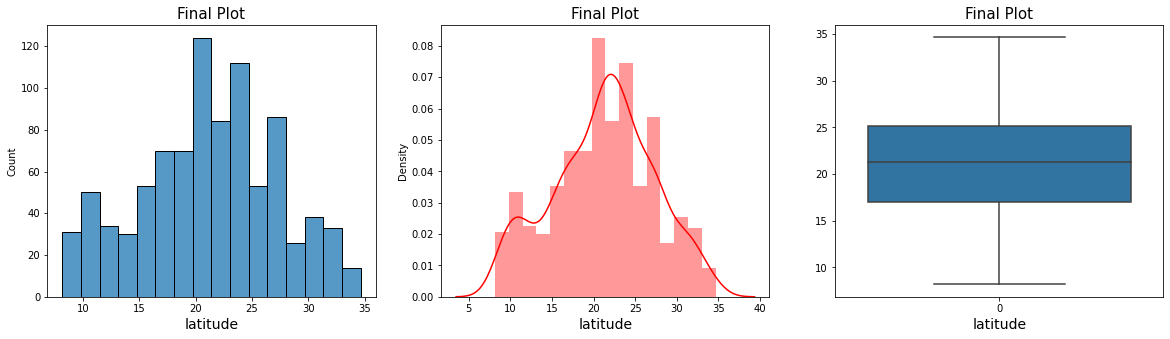

In [40]:
#Visualization
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.histplot(df['latitude']) #visualize the outliers by using histplot
plt.title('Final Plot', fontsize=15)
plt.xlabel('latitude', fontsize= 14)

plt.subplot(1,3,2)
sns.distplot(df['latitude'], color='r') #visualize the normalization curve by using distplot
plt.title('Final Plot', fontsize=15)
plt.xlabel('latitude', fontsize= 14)

plt.subplot(1,3,3)
sns.boxplot(data = df['latitude']) #visualize the outliers by using boxplot
plt.title('Final Plot', fontsize=15)
plt.xlabel('latitude', fontsize= 14)
plt.show()

In [41]:
df.groupby('capacity_mw')['latitude'].value_counts().sort_index(ascending=True).head(10)
#Checking the relationship between capacity_mw and latitude
#The latitude of lowest capacity power plant is 12.8491

capacity_mw  latitude
0.0          12.8491     1
1.0          11.0118     1
             18.0791     1
             20.7325     1
             22.4809     1
             23.1534     1
             26.0748     1
             26.2776     1
             26.5249     1
             26.5653     1
Name: latitude, dtype: int64

In [42]:
df.groupby('capacity_mw')['latitude'].value_counts().sort_index(ascending=False).head(10)
#Checking the relationship between capacity_mw and latitude
#The latitude of Highest capacity power plant is 24.0983

capacity_mw  latitude
4760.0       24.0983     1
4620.0       22.8230     1
4000.0       22.8158     1
3960.0       23.9784     1
3300.0       21.4129     1
3000.0       24.0270     1
             21.0966     1
2980.0       22.1300     1
2920.0       20.0063     1
2630.0       24.2010     1
Name: latitude, dtype: int64

In [43]:
df.groupby('latitude')['primary_fuel'].value_counts().sort_index(ascending=True).head(10)
#Checking the relationship between latitude and primary_fuel
#The lowest latitude is 8.1689 and that is Nuclear Power Plant

latitude  primary_fuel
8.1689    Nuclear         1
8.1691    Nuclear         1
8.1784    Wind            1
8.3091    Wind            1
8.5319    Hydro           1
8.6895    Hydro           1
8.7065    Hydro           1
8.7603    Coal            1
8.7635    Coal            2
8.8230    Wind            1
Name: primary_fuel, dtype: int64

In [44]:
df.groupby('latitude')['primary_fuel'].value_counts().sort_index(ascending=False).head(10)
#Checking the relationship between latitude and primary_fuel
#The Highest latitude is 34.6490 and that is Hydro Power Plant

latitude  primary_fuel
34.6490   Hydro           1
34.5605   Hydro           1
34.4903   Hydro           1
34.2236   Hydro           1
34.2189   Hydro           1
34.2154   Hydro           1
34.1980   Hydro           1
34.1442   Hydro           1
34.0921   Hydro           1
34.0040   Oil             1
Name: primary_fuel, dtype: int64

In [45]:
df.groupby('latitude')['name'].value_counts().sort_index(ascending=False).head(10)
#Checking the relationship between name and latitude
#The Name of the power plant who have highest latitude is Kishenganga

latitude  name             
34.6490   KISHENGANGA          1
34.5605   KARGIL               1
34.4903   CHUTAK               1
34.2236   GANDHARBAL           1
34.2189   LOWER JHELUM         1
34.2154   NIMOO BAZGO          1
34.1980   UPPER SINDH I& II    1
34.1442   URI                  1
34.0921   URI -II              1
34.0040   PAMPORE GT           1
Name: name, dtype: int64

In [46]:
df.groupby('latitude')['name'].value_counts().sort_index(ascending=True).head(10)
#Checking the relationship between name and latitude
#The Name of the lowest latitude power plant is Kundankulam

latitude  name                        
8.1689    Kudankulam                      1
8.1691    KUNDANKULAM                     1
8.1784    Nagercoli Wind Farm             1
8.3091    Karur Textile Park Wind Farm    1
8.5319    KODAYAR-I&II                    1
8.6895    SERVALAR                        1
8.7065    PAPANASAM                       1
8.7603    TUTICORIN JV                    1
8.7635    TUTICORIN                       1
          TUTICORIN- IND BARATH           1
Name: name, dtype: int64

In [47]:
#check the shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (908, 23)


Observation:
1. There is no zero value in this column
2. There are 46 Null values which was replaced by column mean.
3. No Outliers found
4. Skewness of the column is very less
5. Mean, median and mode values are almost equal
6. Latitude of Lowest capacity power plant is 12.8491
7. Latitude of Highest capacity power plant is 24.0983
8. The lowest latitude is 8.1689 and it is Nuclear Powerplant, its name is 'Kudankulam'
9. The highest latitude is 34.6490 and it is Hydro Powerplant, its name is 'KISHENGANGA'
10. So, it means, Northern India have high latitude and they have Hydro Powerplant
11. and Southern India have lowest latitude and they have Nuclear powerplant

# Column5: longitude

In [48]:
df['longitude'].unique() #check the unique value

array([73.2407, 74.609 , 69.3732, 91.3602, 82.4091, 68.6447, 77.0078,
       77.207 , 75.8863, 81.6373, 77.9009, 76.4938, 82.8   , 77.8769,
           nan, 82.7891, 76.3188, 81.7841, 81.7865, 76.1851, 74.7061,
       74.9191, 79.5286, 83.2741, 79.1518, 74.2402, 76.3926, 77.687 ,
       73.6396, 77.1893, 76.3482, 71.6917, 71.6918, 71.6916, 80.2695,
       77.3066, 75.225 , 75.3155, 76.1418, 87.4513, 82.1221, 79.3421,
       74.689 , 82.4305, 88.4042, 76.4695, 81.2875, 81.2747, 74.2562,
       83.1889, 91.565 , 86.0218, 79.925 , 85.7452, 79.8066, 73.2   ,
       80.2682, 78.241 , 76.7986, 74.5345, 79.0547, 74.8209, 74.7111,
       76.7909, 77.1036, 76.7195, 75.6373, 75.7131, 76.4328, 79.6311,
       79.7708, 73.8087, 73.7252, 73.4173, 72.2222, 77.758 , 77.8659,
       77.7145, 74.7529, 81.4237, 73.3907, 73.3498, 73.4527, 75.8425,
       74.6216, 78.1606, 78.1336, 73.0901, 83.2058, 76.6537, 81.0333,
       86.0888, 85.88  , 90.5287, 74.1543, 76.3744, 88.14  , 76.532 ,
       78.9535, 78.9

In [49]:
df['longitude'].value_counts() #check the counts of unique value

71.6917    4
71.6918    3
75.8988    3
72.8983    3
81.2875    3
          ..
80.1264    1
76.1137    1
74.6447    1
86.0970    1
79.5748    1
Name: longitude, Length: 828, dtype: int64

In [50]:
df['longitude'].describe() #check the parameters

count    862.000000
mean      77.447848
std        4.907260
min       68.644700
25%       74.258975
50%       76.719250
75%       79.441475
max       95.408000
Name: longitude, dtype: float64

In [51]:
df['longitude'].all() #check the zero values

True

In [52]:
df['longitude'].isnull().sum() #check the null values

46

In [53]:
df['longitude'].fillna(df['longitude'].mean(), inplace=True) #replace the null values by column mean

In [54]:
df['longitude'].isnull().sum() # Now, check the null values

0

In [55]:
df['longitude'].describe() #check the parameters

count    908.000000
mean      77.447848
std        4.781201
min       68.644700
25%       74.390250
50%       76.978950
75%       79.211600
max       95.408000
Name: longitude, dtype: float64

In [56]:
# Calculate mean, median, mode and std to check the normalization curve
print('Mean of the column:----->',df['longitude'].mean())
print('Median of the column:----->',df['longitude'].median())
print('Mode of the column:----->',st.mode(df['longitude']))
print('std of the column:----->',df['longitude'].std())

Mean of the column:-----> 77.44784779582375
Median of the column:-----> 76.97895
Mode of the column:-----> 77.44784779582372
std of the column:-----> 4.781200569915295


In [57]:
df['longitude'].skew() #check the skewness

1.1298360340203166

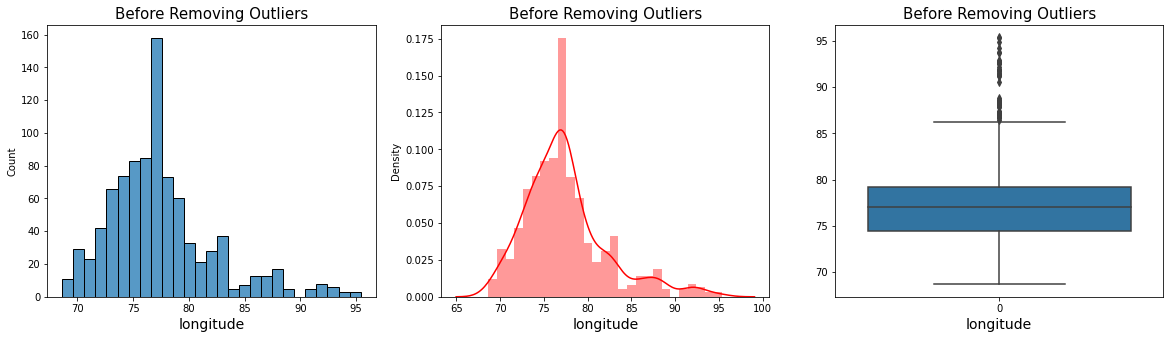

In [58]:
#Visualization
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.histplot(df['longitude']) #visualize the outliers by using histplot
plt.title('Before Removing Outliers', fontsize=15)
plt.xlabel('longitude', fontsize= 14)

plt.subplot(1,3,2)
sns.distplot(df['longitude'], color='r') #visualize the normalization curve by using distplot
plt.title('Before Removing Outliers', fontsize=15)
plt.xlabel('longitude', fontsize= 14)

plt.subplot(1,3,3)
sns.boxplot(data = df['longitude']) #visualize the outliers by using boxplot
plt.title('Before Removing Outliers', fontsize=15)
plt.xlabel('longitude', fontsize= 14)
plt.show()

In [59]:
#Detecting the outlier by using iqr method and removing them.
q1 = np.percentile(df['longitude'], 25,
                   interpolation = 'midpoint')
 
q3 = np.percentile(df['longitude'], 69,
                   interpolation = 'midpoint')
iqr = q3 - q1
print('Inter quartile range:------>',iqr)
print("\n",'*'*50)

# higher side 
higher_side = df['longitude'] >= (q3+1.5*iqr)
print('Higher range:-\n',np.where(higher_side))
print("\n",'*'*50)

# lower side 
lower_side = df['longitude'] <= (q1-1.5*iqr)
print('Lower range:- \n',np.where(lower_side))

Inter quartile range:------> 3.7825499999999863

 **************************************************
Higher range:-
 (array([  3,  45,  51,  59,  60,  62, 102, 103, 104, 108, 143, 152, 158,
       168, 178, 180, 184, 189, 190, 210, 240, 245, 254, 262, 272, 278,
       279, 288, 296, 297, 300, 309, 320, 324, 334, 341, 351, 353, 361,
       368, 389, 417, 428, 448, 455, 456, 472, 473, 481, 499, 500, 512,
       520, 530, 547, 568, 571, 601, 623, 637, 639, 640, 648, 653, 679,
       694, 734, 739, 740, 786, 787, 794, 796, 797, 798, 799, 800, 802,
       808, 810, 819, 828, 841, 848, 849], dtype=int64),)

 **************************************************
Lower range:- 
 (array([  5, 412, 563], dtype=int64),)


In [60]:
#First print the old shape and then compare
print("old Shape:------> ", df.shape)
#removing the outliers
high=np.where(higher_side)
low=np.where(lower_side)
df=df.drop(df.index[high])
df=df.drop(df.index[low])
 
print("New Shape:------> ", df.shape)

old Shape:------>  (908, 23)
New Shape:------>  (820, 23)


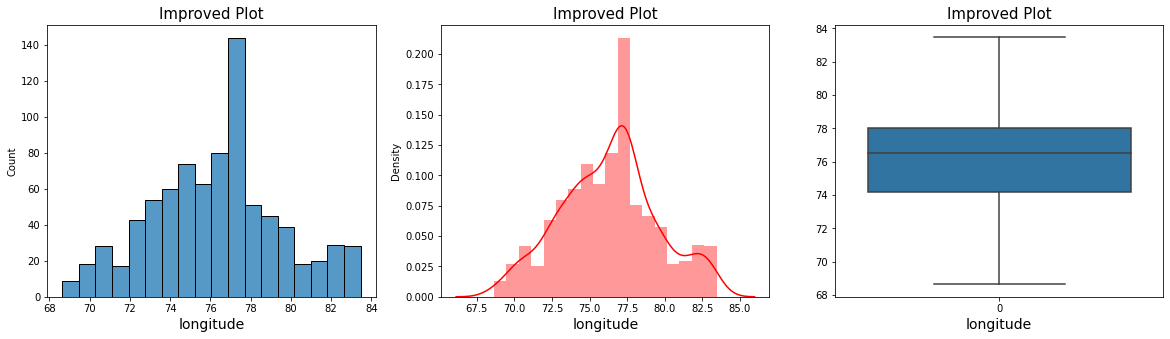

In [61]:
#Visualization
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.histplot(df['longitude']) #visualize the outliers by using histplot
plt.title('Improved Plot', fontsize=15)
plt.xlabel('longitude', fontsize= 14)

plt.subplot(1,3,2)
sns.distplot(df['longitude'], color='r') #visualize the normalization curve by using distplot
plt.title('Improved Plot', fontsize=15)
plt.xlabel('longitude', fontsize= 14)

plt.subplot(1,3,3)
sns.boxplot(data = df['longitude']) #visualize the outliers by using boxplot
plt.title('Improved Plot', fontsize=15)
plt.xlabel('longitude', fontsize= 14)
plt.show()

In [62]:
# Calculate mean, median, mode and std to check the normalization curve
print('Mean of the column:----->',df['longitude'].mean())
print('Median of the column:----->',df['longitude'].median())
print('Mode of the column:----->',st.mode(df['longitude']))
print('std of the column:----->',df['longitude'].std()) #parameters are not good right now

Mean of the column:-----> 76.30781694952195
Median of the column:-----> 76.53184999999999
Mode of the column:-----> 77.44784779582372
std of the column:-----> 3.224219473389339


In [63]:
df['longitude'] = df['longitude'].replace(77.44784779582372, df['longitude'].mean())
#replace mode by column mean value to get good curve

In [64]:
# Calculate mean, median, mode and std to check the normalization curve
print('Mean of the column:----->',df['longitude'].mean())
print('Median of the column:----->',df['longitude'].median())
print('Mode of the column:----->',st.mode(df['longitude']))
print('std of the column:----->',df['longitude'].std()) #Now, it is looking better

Mean of the column:-----> 76.2438639996073
Median of the column:-----> 76.30781694952195
Mode of the column:-----> 76.30781694952195
std of the column:-----> 3.212242033553605


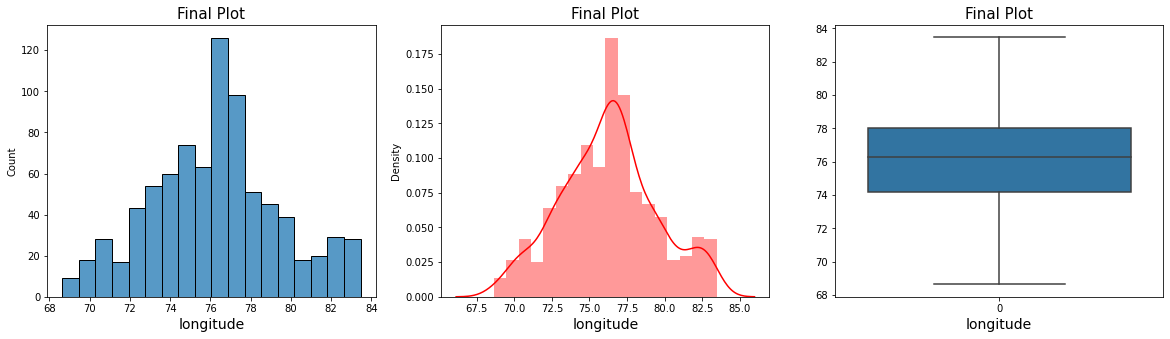

In [65]:
#Visualization
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.histplot(df['longitude']) #visualize the outliers by using histplot
plt.title('Final Plot', fontsize=15)
plt.xlabel('longitude', fontsize= 14)

plt.subplot(1,3,2)
sns.distplot(df['longitude'], color='r') #visualize the normalization curve by using distplot
plt.title('Final Plot', fontsize=15)
plt.xlabel('longitude', fontsize= 14)

plt.subplot(1,3,3)
sns.boxplot(data = df['longitude']) #visualize the outliers by using boxplot
plt.title('Final Plot', fontsize=15)
plt.xlabel('longitude', fontsize= 14)
plt.show()

In [66]:
df['longitude'].skew() #Now, check the skewness

0.09427580682186866

In [67]:
df.groupby('capacity_mw')['longitude'].value_counts().sort_index(ascending=True).head(10)
#Checking the relationship between capacity_mw and longitude
#The longitude of lowest capacity power plant is 77.6752

capacity_mw  longitude
0.0          77.6752      1
1.0          70.8304      1
             71.5212      1
             71.5322      1
             72.2677      1
             72.3236      1
             72.5235      1
             72.5377      1
             72.6510      1
             72.6690      1
Name: longitude, dtype: int64

In [68]:
df.groupby('capacity_mw')['longitude'].value_counts().sort_index(ascending=False).head(10)
#Checking the relationship between capacity_mw and longitude
#The longitude of Highest capacity power plant is 82.6719

capacity_mw  longitude
4760.0       82.6719      1
4620.0       69.5532      1
4000.0       69.5281      1
3960.0       82.6275      1
3300.0       79.9671      1
3000.0       82.7915      1
2980.0       82.2930      1
2920.0       79.2900      1
2630.0       82.7891      1
2600.0       82.6858      1
Name: longitude, dtype: int64

In [69]:
df.groupby('longitude')['primary_fuel'].value_counts().sort_index(ascending=True).head(10)
#Checking the relationship between longitude and primary_fuel
#The lowest longitude is 68.6447 and that is Coal Based Power Plant

longitude  primary_fuel
68.6447    Coal            1
68.6975    Wind            1
68.6988    Wind            1
68.7653    Solar           1
68.7843    Coal            1
68.8782    Wind            1
68.9925    Solar           1
69.0255    Solar           1
69.3732    Wind            1
69.5281    Coal            1
Name: primary_fuel, dtype: int64

In [70]:
df.groupby('longitude')['primary_fuel'].value_counts().sort_index(ascending=False).head(10)
#Checking the relationship between longitude and primary_fuel
#The Highest longitude is 83.4632 and that is Solar Power Plant

longitude  primary_fuel
83.4632    Solar           1
83.4573    Coal            1
83.4538    Solar           1
83.4513    Coal            1
83.2788    Coal            1
83.2741    Coal            1
83.2331    Coal            1
83.2058    Coal            1
83.1889    Coal            1
83.1382    Coal            1
Name: primary_fuel, dtype: int64

In [71]:
df.groupby('longitude')['name'].value_counts().sort_index(ascending=False).head(10)
#Checking the relationship between name and longitude
#The Name of the power plant who have highest longitude is Sadeipali - REHPL Solar Power Plant

longitude  name                               
83.4632    Sadeipali - REHPL Solar Power Plant    1
83.4573    LARA                                   1
83.4538    Sadeipali - ASPL Solar Power Plant     1
83.4513    TAMNAR TPP                             1
83.2788    NAWAPARA                               1
83.2741    AVANTHA BHANDAR TPP                    1
83.2331    RAIGARH TPP                            1
83.2058    BINJKOTE                               1
83.1889    BARADARHA TPP                          1
83.1382    VIZAG TPP                              1
Name: name, dtype: int64

In [72]:
df.groupby('longitude')['name'].value_counts().sort_index(ascending=True).head(10)
#Checking the relationship between name and longitude
#The Name of the lowest longitude power plant is AKRIMOTA LIG

longitude  name                       
68.6447    AKRIMOTA LIG                   1
68.6975    ONGC Kutch Wind Farm           1
68.6988    Kosa Wind Farm                 1
68.7653    Panandhro Solar Power Plant    1
68.7843    KUTCH LIG.                     1
68.8782    Bera Wind Farm                 1
68.9925    Mithapur Solar Power Plant     1
69.0255    Bitta Solar Power Plant        1
69.3732    AES Saurashtra Windfarms       1
69.5281    MUNDRA UMPP                    1
Name: name, dtype: int64

In [73]:
#check the shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (820, 23)


Observation:
1. There is no zero value in this column
2. There are 46 Null values which was replaced by column mean.
3. Outliers found and we removed outliers
4. Earlier, Skewness of the column is 1.12 and now, it is 0.094
5. Mean, median and mode values are almost equal
6. longitude of Lowest capacity power plant is 77.6752
7. longitude of Highest capacity power plant is 82.6719
8. The lowest longitude is 68.6447 and it is Coal based Powerplant, its name is 'AKRIMOTA LIG'
9. The highest longitude is 83.4632 and it is Solar Powerplant, its name is 'Sadeipali - REHPL Solar Power Plant'
10. So, it means, Eastern India have high longitude.
11. and Western India have lowest longitude.

# Column6: other_fuel1

In [74]:
df['other_fuel1'].unique() #check the unique value

array([nan, 'Oil', 'Cogeneration', 'Gas'], dtype=object)

In [75]:
df['other_fuel1'].value_counts() #check the counts of unique value

Oil             157
Gas               2
Cogeneration      1
Name: other_fuel1, dtype: int64

In [76]:
df['other_fuel1'].all() #check the zero values

True

In [77]:
df['other_fuel1'].isnull().sum() #check the null values

660

In [78]:
df.drop(columns = ['other_fuel1'], inplace = True) #drop the column

In [79]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (820, 22)


Observation:
1. No Zero values found
2. Column contains only 3 category:
3. Oil - 157
4. Gas- 2
5. Cogeneration - 1
6. Huge amount of Null Values, 660 numbers
7. It is better to drop this column instead of replacing this Null values to any other category.
8. if we drop this Null values than we can loose some useful information also. 
9. So, we decided to drop this column.

# Column7: other_fuel2

In [80]:
df['other_fuel2'].unique() #check the unique values

array([nan, 'Oil'], dtype=object)

In [81]:
df['other_fuel2'].value_counts()  #check the counts of unique value

Oil    1
Name: other_fuel2, dtype: int64

In [82]:
df['other_fuel2'].all() #check the zero values

True

In [83]:
df['other_fuel2'].isnull().sum() #check the null values

819

In [84]:
df.drop(columns = ['other_fuel2'], inplace = True) #drop the column

In [85]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (820, 21)


Observation:
1. No zero values found
2. Column contains only null values except one value that is Oil
3. So, it is better to drop this column instead of replacing all null values into Oil.

# Column8: other_fuel3

In [86]:
df['other_fuel3'].unique() #check the unique value

array([nan])

In [87]:
df['other_fuel3'].value_counts() #check the counts of unique value

Series([], Name: other_fuel3, dtype: int64)

In [88]:
df['other_fuel3'].all() #check the zero values

True

In [89]:
df.drop(columns = ['other_fuel3'], inplace = True) #drop the column

In [90]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (820, 20)


Observation:
1. No zero value found
2. Column contains all null values
3. So, it is better to drop this column

# Column9: commissioning_year

In [91]:
df['commissioning_year'].unique() #check the unique values

array([2011.,   nan, 2015., 2005., 2010., 2004., 2008., 2014., 1985.,
       1986., 1987., 2000., 1989., 2017., 1998., 1977., 1980., 1984.,
       1996., 1991., 2002., 2001., 2006., 1988., 2003., 1973., 2012.,
       1968., 1964., 2016., 2013., 1962., 2007., 1997., 1999., 1994.,
       1975., 1992., 1972., 1979., 1967., 1995., 1983., 1959., 1993.,
       1961., 1957., 1978., 1976., 1963., 1981., 1955., 2018., 1970.,
       2009., 1966., 1965., 1960., 1949., 1952., 1990., 1982., 1937.,
       1956., 1946., 1958., 1943., 1954., 1969., 1939., 1971., 1927.,
       1974.])

In [92]:
df['commissioning_year'].value_counts() #check the counts of unique values

2013.0    24
2015.0    22
2012.0    19
2016.0    16
2014.0    15
          ..
1971.0     1
1927.0     1
1954.0     1
1956.0     1
1946.0     1
Name: commissioning_year, Length: 72, dtype: int64

In [93]:
df['commissioning_year'].all() #check the zero values in column

True

In [94]:
df['commissioning_year'].isnull().sum() #check the null values

376

In [95]:
df.dropna(subset=["commissioning_year"], inplace=True) #drop the null values

In [96]:
df['commissioning_year'].isnull().sum() #Now, check the null values

0

In [97]:
df['commissioning_year'].unique() #Now, check the unique values

array([2011., 2015., 2005., 2010., 2004., 2008., 2014., 1985., 1986.,
       1987., 2000., 1989., 2017., 1998., 1977., 1980., 1984., 1996.,
       1991., 2002., 2001., 2006., 1988., 2003., 1973., 2012., 1968.,
       1964., 2016., 2013., 1962., 2007., 1997., 1999., 1994., 1975.,
       1992., 1972., 1979., 1967., 1995., 1983., 1959., 1993., 1961.,
       1957., 1978., 1976., 1963., 1981., 1955., 2018., 1970., 2009.,
       1966., 1965., 1960., 1949., 1952., 1990., 1982., 1937., 1956.,
       1946., 1958., 1943., 1954., 1969., 1939., 1971., 1927., 1974.])

In [98]:
df['commissioning_year'].value_counts() #check the counts of unique values

2013.0    24
2015.0    22
2012.0    19
2016.0    16
2010.0    15
          ..
1971.0     1
1959.0     1
1943.0     1
1939.0     1
1974.0     1
Name: commissioning_year, Length: 72, dtype: int64

In [99]:
df.groupby('latitude')['commissioning_year'].value_counts().sort_index(ascending=False).head(10)
#Checking the relationship between commissioning_year and latitude

latitude  commissioning_year
34.6490   2018.0                1
34.5605   1995.0                1
34.4903   2012.0                1
34.2236   1959.0                1
34.2189   1978.0                1
34.2154   2013.0                1
34.1980   1996.0                1
34.1442   1996.0                1
34.0921   2013.0                1
34.0040   1992.0                1
Name: commissioning_year, dtype: int64

In [100]:
df['commissioning_year'][df.latitude==24.0983].value_counts()

2002.0    1
Name: commissioning_year, dtype: int64

In [101]:
df.groupby('commissioning_year')['primary_fuel'].value_counts().sort_index(ascending=False).head(50)
#Checking the relationship between commissioning_year and primary_fuel

commissioning_year  primary_fuel
2018.0              Hydro            1
                    Coal             2
2017.0              Hydro            3
                    Coal             5
2016.0              Hydro            2
                    Gas              3
                    Coal            11
2015.0              Solar            1
                    Nuclear          1
                    Hydro            4
                    Gas              1
                    Coal            15
2014.0              Solar            3
                    Hydro            1
                    Gas              1
                    Coal            10
2013.0              Solar            3
                    Hydro            4
                    Gas              1
                    Coal            16
2012.0              Hydro            4
                    Gas              3
                    Coal            12
2011.0              Solar            1
                    Hydro      

Text(0.5, 0, 'commissioning_year')

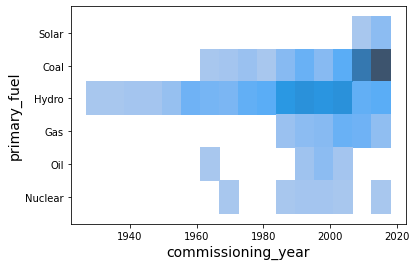

In [102]:
#visualize this column by Histplot
#Check the relationship between primary_fuel and commissioning_year
sns.histplot(y = 'primary_fuel', x = 'commissioning_year', data=df)
plt.ylabel('primary_fuel', fontsize = 14)
plt.xlabel('commissioning_year', fontsize = 14)

In [103]:
#check the Actual shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (444, 20)


Observation:
1. No zero values found
2. Null values are found, we drop the null values for further analysis.
3. 2013 is the highest commissioning year for powerplants.
4. We can see, every year commissioning of Coal Plants are high than others.
5. The commissioning year of 4760.0 MW is 2002.0, rest, 0.0MW values are Null values. 

# Column10: gppd_idnr

In [104]:
df['gppd_idnr'].unique() #check the unique values

array(['WRI1020239', 'IND0000002', 'IND0000003', 'IND0000005',
       'IND0000006', 'IND0000007', 'IND0000008', 'IND0000009',
       'IND0000010', 'IND0000011', 'IND0000012', 'IND0000013',
       'IND0000014', 'IND0000015', 'IND0000016', 'IND0000017',
       'WRI1020238', 'IND0000018', 'IND0000019', 'IND0000020',
       'IND0000021', 'IND0000022', 'IND0000025', 'IND0000024',
       'IND0000026', 'IND0000028', 'IND0000029', 'IND0000030',
       'IND0000031', 'IND0000032', 'IND0000033', 'IND0000036',
       'IND0000038', 'IND0000039', 'IND0000040', 'IND0000041',
       'IND0000042', 'IND0000044', 'IND0000045', 'IND0000046',
       'IND0000047', 'IND0000048', 'IND0000049', 'IND0000050',
       'IND0000514', 'IND0000052', 'IND0000053', 'IND0000051',
       'IND0000054', 'IND0000055', 'IND0000056', 'IND0000057',
       'IND0000058', 'IND0000059', 'IND0000527', 'IND0000060',
       'IND0000061', 'IND0000067', 'IND0000068', 'IND0000070',
       'IND0000071', 'IND0000072', 'IND0000073', 'IND00

In [105]:
df['gppd_idnr'].value_counts() #check the counts of unique values

IND0000444    1
IND0000358    1
IND0000404    1
IND0000225    1
IND0000434    1
             ..
IND0000535    1
IND0000204    1
IND0000333    1
IND0000432    1
IND0000016    1
Name: gppd_idnr, Length: 444, dtype: int64

In [106]:
df['gppd_idnr'].isnull().sum() #check the null values

0

In [107]:
lab_enc = LabelEncoder() #using Label Encoder to transform our column data
df['gppd_idnr'] = pd.Series(lab_enc.fit_transform(df['gppd_idnr']))

In [108]:
df['gppd_idnr'].unique() #check the unique values

array([437.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14., 436.,  16.,  21.,  20.,  23.,  37.,  38.,  40.,  41., 417.,
        44.,  42.,  47.,  49.,  50., 429.,  51.,  52.,  54.,  57.,  59.,
        60.,  61., 418.,  62.,  69.,  71.,  72.,  74.,  77.,  78.,  79.,
        80.,  81.,  82.,  83., 438., 439.,  85.,  86.,  88.,  91.,  92.,
        93.,  94.,  99., 100., 102.,  87., 124., 128., 129., 130., 137.,
       138., 139., 140., 141., 142., 143., 144., 150., 151., 152., 154.,
       157., 159., 160., 161., 162., 163., 164., 165., 166., 169., 172.,
       174., 176., 183., 184., 186., 187., 189., 195., 197., 200., 423.,
       201., 202., 203., 204., 205., 206., 432., 208., 209., 210., 211.,
       213., 215., 216., 217., 218., 220., 228., 232., 236., 238., 240.,
       241., 248., 252., 253., 254., 255., 259., 260., 261., 265., 268.,
       273., 274., 276., 286., 287., 288., 290., 291., 292., 293., 294.,
       295., 296., 297., 301., 303., 281., 304., 30

In [109]:
df['gppd_idnr'].value_counts() #check the counts of unique values

350.0    1
69.0     1
364.0    1
254.0    1
343.0    1
        ..
297.0    1
355.0    1
62.0     1
429.0    1
436.0    1
Name: gppd_idnr, Length: 208, dtype: int64

Text(0, 0.5, 'Counts')

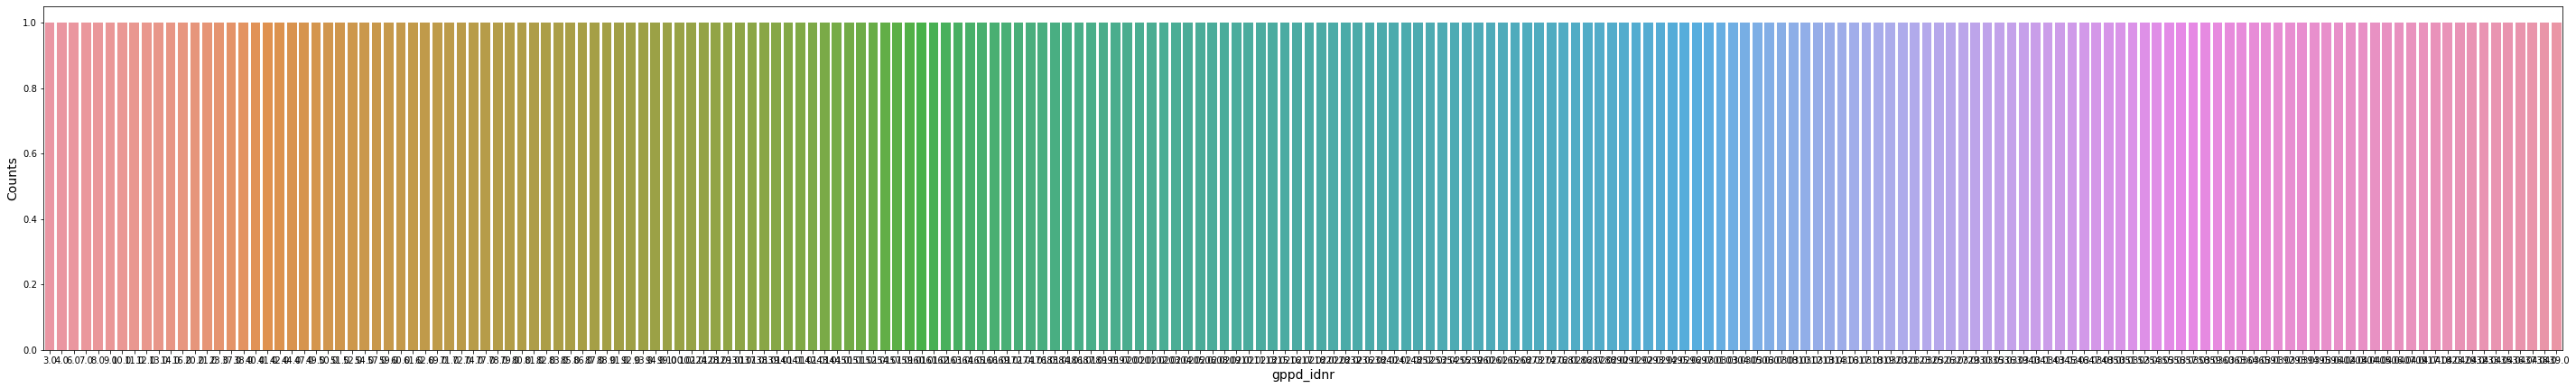

In [110]:
#visualize this column by Countplot
plt.figure(figsize =(50,7))
sns.countplot(x = 'gppd_idnr', data=df)
plt.xlabel('gppd_idnr', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)

In [111]:
df.drop(columns = ['gppd_idnr'], inplace = True) #drop the column

In [112]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (444, 19)


Observation:
1. No zero values are found
2. All the values are unique in this column
3. there are some null values also, but if we convert null values into other value,
4. then normal curve will not look good
5. It is better to drop this column

# Column11: Owner

In [113]:
df['owner'].unique() #check the unique values

array(['Solar Paces', nan, 'Ener-t International Ltd.', 'Reliance Power',
       'Lanco Infratech', 'Godwari Green Energy Limited',
       'Cargo Solar Power', 'KVK Energy Ventures Ltd',
       'Megha Engineering and Infrastructure'], dtype=object)

In [114]:
df['owner'].value_counts() #check the counts of unique values

Cargo Solar Power                       1
Reliance Power                          1
Solar Paces                             1
Godwari Green Energy Limited            1
KVK Energy Ventures Ltd                 1
Lanco Infratech                         1
Ener-t International Ltd.               1
Megha Engineering and Infrastructure    1
Name: owner, dtype: int64

In [115]:
df['owner'].isnull().sum() #check the for null values

436

In [116]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (444, 19)


In [117]:
#percentage of null values in our column 
print('Percentage of Null values in our column:----->',(df['owner'].isnull().sum())/(df.shape)*100)

Percentage of Null values in our column:-----> [  98.1981982  2294.73684211]


In [118]:
df.drop(columns = ['owner'], inplace = True) #drop the column

In [119]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (444, 18)


Observation:
1. 98.198% Null Values are found in this column, that's why we drop this column

# Columns12: source

In [120]:
df['source'].unique() #check the unique values

array(['National Renewable Energy Laboratory',
       'Central Electricity Authority'], dtype=object)

In [121]:
df['source'].value_counts() #check the counts of unique values

Central Electricity Authority           436
National Renewable Energy Laboratory      8
Name: source, dtype: int64

In [122]:
df['source'].isnull().sum() #check for null values

0

In [123]:
df.groupby('source')['primary_fuel'].value_counts().sort_index(ascending=True).head(50)
#Checking the relationship between source and primary_fuel

source                                primary_fuel
Central Electricity Authority         Coal            152
                                      Gas              50
                                      Hydro           213
                                      Nuclear           8
                                      Oil              13
National Renewable Energy Laboratory  Solar             8
Name: primary_fuel, dtype: int64

In [124]:
df.groupby('source')['capacity_mw'].value_counts().sort_index(ascending=True).head(100)
#Checking the relationship between source and primary_fuel

source                         capacity_mw
Central Electricity Authority  3.30           1
                               3.75           3
                               4.00           4
                               4.50           3
                               4.80           1
                                             ..
                               165.00         1
                               172.00         1
                               175.00         1
                               180.00         3
                               186.00         1
Name: capacity_mw, Length: 100, dtype: int64

In [125]:
#check the relationship between capacity_mw and source
df.groupby('capacity_mw').source.min() 

capacity_mw
2.50       National Renewable Energy Laboratory
3.30              Central Electricity Authority
3.75              Central Electricity Authority
4.00              Central Electricity Authority
4.50              Central Electricity Authority
                           ...                 
3300.00           Central Electricity Authority
3960.00           Central Electricity Authority
4000.00           Central Electricity Authority
4620.00           Central Electricity Authority
4760.00           Central Electricity Authority
Name: source, Length: 235, dtype: object

In [126]:
#check the source of highest capacity in mw power plant
df['capacity_mw'][df.source=='Central Electricity Authority'].max()

4760.0

In [127]:
#Check the counts of primary fuel in Central Electricity Authority
df['primary_fuel'][df.source=='Central Electricity Authority'].value_counts()

Hydro      213
Coal       152
Gas         50
Oil         13
Nuclear      8
Name: primary_fuel, dtype: int64

In [128]:
#change the string value into integer
df['source'] = df['source'].map({'Central Electricity Authority':1, 'National Renewable Energy Laboratory':0})

In [129]:
df['source'].unique() #check the unique values now

array([0, 1], dtype=int64)

Observation:
1. No zero values found
2. Central Electricity Authority makes coal and hydro power plants more
3. The source of highest capacity power plant '4760.0' is Central Electricity Authority
4. 'Central Electricity Authority' = 1
5. 'National Renewable Energy Laboratory' = 0

# Column13: Url

In [130]:
df['url'].unique() #Check the unique values

array(['http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=262',
       'http://www.cea.nic.in/',
       'http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=254',
       'http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=272',
       'http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=258',
       'http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=247',
       'http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=263',
       'http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=260',
       'http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=264'],
      dtype=object)

In [131]:
df['url'].value_counts() #check the counts of unique values

http://www.cea.nic.in/                                                 436
http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=272      1
http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=264      1
http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=254      1
http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=247      1
http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=263      1
http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=258      1
http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=260      1
http://www.nrel.gov/csp/solarpaces/project_detail.cfm/projectID=262      1
Name: url, dtype: int64

In [132]:
df.drop(columns = ['url'], inplace = True) #drop the column

In [133]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (444, 17)


# column14: geolocation_source

In [134]:
df['geolocation_source'].unique() #check the null values 

array(['National Renewable Energy Laboratory', 'WRI', nan], dtype=object)

In [135]:
df['geolocation_source'].value_counts() #check the counts of unique values

WRI                                     436
National Renewable Energy Laboratory      4
Name: geolocation_source, dtype: int64

In [136]:
df['geolocation_source'].isnull().sum() #check the null values

4

In [137]:
df.dropna(subset=["geolocation_source"], inplace=True) #drop the null values

In [138]:
df['geolocation_source'].unique() #check the null values 

array(['National Renewable Energy Laboratory', 'WRI'], dtype=object)

In [139]:
df.groupby('geolocation_source')['primary_fuel'].value_counts().sort_index(ascending=True).head(50)

geolocation_source                    primary_fuel
National Renewable Energy Laboratory  Solar             4
WRI                                   Coal            152
                                      Gas              50
                                      Hydro           213
                                      Nuclear           8
                                      Oil              13
Name: primary_fuel, dtype: int64

In [140]:
df['geolocation_source'].unique()#check the null values 

array(['National Renewable Energy Laboratory', 'WRI'], dtype=object)

In [141]:
df.drop(columns = ['geolocation_source'], inplace = True) #drop the column

Observation:
1. There are only two Categories: WRI and National Renewable Energy Laboratory
2. 4 Null values are found and treated by using dropna method
3. WRI is 436 now and National Renewable Energy Laboratory and 4 now
4. if we look at 'source' column, 
5. it has 'Central Electricity Authority'-436 and 'National Renewable Energy Laboratory' - 8 but now, it has 4 beacuse we drop 4 null values which are in 'geolocation_source' column.
6. So, both the columns are exactly similar

In [142]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (440, 16)


# Column15: wepp_id

In [143]:
df['wepp_id'].unique() #check the unique values

array([nan])

In [144]:
df['wepp_id'].value_counts() # check the counts of unique values

Series([], Name: wepp_id, dtype: int64)

In [145]:
df.drop(columns = ['wepp_id'], inplace = True) #drop the column

Observation:
1. There is nothing in this column, all values are null, so, we drop this column

In [146]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (440, 15)


# Column16: year_of_capacity_data

In [147]:
df['year_of_capacity_data'].unique() #check the unique values

array([  nan, 2018.])

In [148]:
df['year_of_capacity_data'].value_counts() # check the counts of unique values

2018.0    436
Name: year_of_capacity_data, dtype: int64

In [149]:
df.drop(columns = ['year_of_capacity_data'], inplace = True) #drop the column

Observation:
1. all values are same in this column if we remove null values
2. So, we drop this column

In [150]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (440, 14)


# Column17: generation_gwh_2013

In [151]:
df['generation_gwh_2013'].unique() #check the unique values

array([           nan, 1.66829000e+03, 8.21798000e+02, 6.96738800e+02,
       5.04813250e+02, 2.64232200e+03, 1.03405000e+03, 7.31334950e+02,
       6.39700000e+03, 7.13299500e+03, 1.91994200e+03, 1.73000000e+03,
       0.00000000e+00, 8.04286000e+02, 3.76900000e+03, 2.78580100e+03,
       6.34849800e+02, 1.64754090e+03, 1.65046620e+03, 1.47080900e+02,
       1.23778000e+02, 2.27570000e+00, 5.44672950e+02, 4.48100000e+02,
       1.25663600e+03, 8.21705000e-01, 1.33876255e+03, 2.27506750e+02,
       5.65200000e+03, 6.34710500e+01, 6.17923855e+03, 9.03460000e+01,
       8.56894000e+01, 2.49148000e+01, 4.10935000e+01, 3.31861000e+03,
       9.64612700e+02, 9.48732500e+01, 3.03007350e+02, 4.36099800e+03,
       1.42839040e+03, 2.79729000e+01, 3.36680000e+02, 2.20064150e+02,
       4.16100000e+02, 3.30880000e+00, 1.38911950e+03, 2.32916565e+03,
       9.33170700e+02, 9.91777200e+03, 8.65650000e+01, 2.82268300e+03,
       9.45051000e+02, 7.80686950e+02, 3.40091000e+01, 1.23120000e+04,
      

In [152]:
df['generation_gwh_2013'].value_counts() # check the counts of unique values

0.00000       19
2942.81000     1
246.42170      1
504.81325      1
1256.63600     1
              ..
1647.54090     1
2329.16565     1
84.86355       1
22.75500       1
137.01150      1
Name: generation_gwh_2013, Length: 306, dtype: int64

In [153]:
df['generation_gwh_2013'].isnull().sum() #check the null values

116

In [154]:
df.dropna(subset=["generation_gwh_2013"], inplace=True) #drop the null values

In [155]:
df['generation_gwh_2013'].isnull().sum() #check the null values

0

In [156]:
df['generation_gwh_2013'].all() #check the zero values

False

In [157]:
#replace the zeros with mean of the column
df['generation_gwh_2013'] = df['generation_gwh_2013'].replace(0.0, df['generation_gwh_2013'].mean())

In [158]:
df['generation_gwh_2013'].all()#check the zero values

True

In [159]:
df['generation_gwh_2013'].value_counts() # check the counts of unique values

2290.110318    19
2785.801000     1
186.779240      1
246.421700      1
504.813250      1
               ..
1627.033950     1
1647.540900     1
2329.165650     1
84.863550       1
137.011500      1
Name: generation_gwh_2013, Length: 306, dtype: int64

In [160]:
#check the relationship between capacity_mw and generation_gwh_2013
df.groupby('capacity_mw')['generation_gwh_2013'].value_counts().sort_index(ascending=True).tail(1)

capacity_mw  generation_gwh_2013
4760.0       26761.39               1
Name: generation_gwh_2013, dtype: int64

Text(0, 0.5, 'capacity_mw')

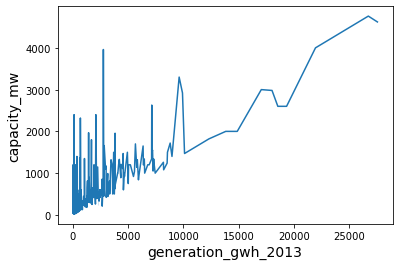

In [161]:
#visualize this column by lineplot
sns.lineplot(x= 'generation_gwh_2013', y = 'capacity_mw', data=df)
plt.xlabel('generation_gwh_2013', fontsize = 14)
plt.ylabel('capacity_mw', fontsize = 14)

Text(0, 0.5, 'primary_fuel')

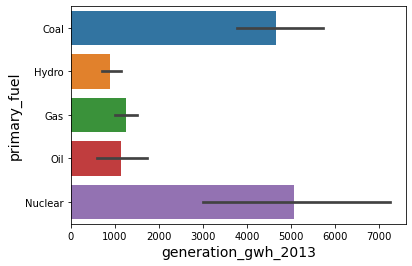

In [162]:
#visualize this column by barplot
sns.barplot(x= 'generation_gwh_2013', y = 'primary_fuel', data=df)
plt.xlabel('generation_gwh_2013', fontsize = 14)
plt.ylabel('primary_fuel', fontsize = 14)

Observation:
1. Zero values and Null values are found
2. We can see, the highest capacity power plant have 26761.39 Generation in gwh in 2013
3. We can see, the power plant those have less capacity generates less.
4. we can see, coal and nuclear powe rplants generates high than others

In [163]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (324, 14)


# Column18: generation_gwh_2014

In [164]:
df['generation_gwh_2014'].unique() #check the unique values

array([3.03555000e+03, 1.15342100e+03, 6.74391100e+02, 4.80594950e+02,
       1.88790400e+03, 1.92097100e+03, 6.14412500e+02, 7.74400000e+03,
       9.67087900e+03, 1.61198700e+03, 1.60700000e+03, 0.00000000e+00,
       5.73274000e+02, 2.93600000e+03, 2.92521045e+03, 7.92686650e+02,
       1.33253385e+03, 1.07595320e+03, 8.56595500e+01, 1.20444750e+02,
       2.65780000e+02, 4.95967700e+02, 5.05760000e+02, 1.25573200e+03,
       2.85387000e+00, 1.24631710e+03, 2.93534950e+02, 5.44576300e+03,
       5.03370500e+01, 5.24180925e+03, 6.50730000e+01, 1.36872200e+02,
       6.75605000e+01, 2.96272000e+03, 8.32884650e+02, 9.07937500e+01,
       2.99176600e+02, 5.85507000e+03, 2.23699080e+03, 8.11580000e+00,
       1.45560000e+02, 2.34650850e+02, 3.30595670e+03, 3.73919000e+02,
       1.49121645e+03, 2.53904100e+03, 1.01567610e+03, 1.13858420e+04,
       5.71269300e+01, 4.08853900e+03, 8.67739500e+02, 7.96487550e+02,
       3.53225000e+01, 1.14660000e+04, 2.46200000e+03, 3.13530470e+03,
      

In [165]:
df['generation_gwh_2014'].value_counts() # check the counts of unique values

0.00000       24
191.97530      1
113.29070      1
34.65585       1
1310.98215     1
              ..
2790.00000     1
6147.80000     1
7744.00000     1
517.19105      1
106.66400      1
Name: generation_gwh_2014, Length: 301, dtype: int64

In [166]:
df['generation_gwh_2014'].isnull().sum() #check the null values

0

In [167]:
#check the relationship between capacity_mw and generation_gwh_2014
df.groupby('capacity_mw')['generation_gwh_2014'].value_counts().sort_index(ascending=True).tail(1)

capacity_mw  generation_gwh_2014
4760.0       27594.0                1
Name: generation_gwh_2014, dtype: int64

Text(0, 0.5, 'capacity_mw')

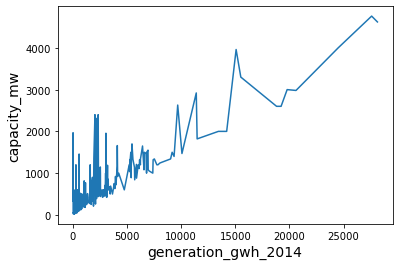

In [168]:
#visualize this column by lineplot
sns.lineplot(x= 'generation_gwh_2014', y = 'capacity_mw', data=df)
plt.xlabel('generation_gwh_2014', fontsize = 14)
plt.ylabel('capacity_mw', fontsize = 14)

Text(0, 0.5, 'primary_fuel')

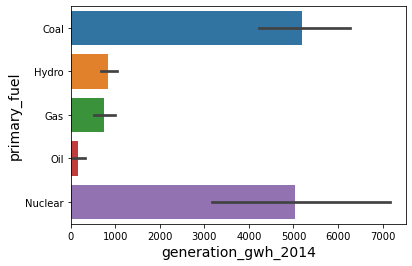

In [169]:
#visualize this column by barplot
sns.barplot(x= 'generation_gwh_2014', y = 'primary_fuel', data=df)
plt.xlabel('generation_gwh_2014', fontsize = 14)
plt.ylabel('primary_fuel', fontsize = 14)

observation:
1. Zero values and Null values are found
2. We can see, the highest capacity power plant '4760.0' have 27594.0 generation in ghw in 2014
3. We can see, the power plant those have less capacity generates less.
4. we can see, coal and nuclear power plants generates higher than others

In [170]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (324, 14)


# Column18: generation_gwh_2015

In [171]:
df['generation_gwh_2015'].unique() #check the unique values

array([5.91637000e+03, 1.20885200e+03, 7.21335200e+02, 1.44434200e+02,
       1.64304600e+03, 5.62966300e+03, 6.65197300e+02, 8.07681050e+03,
       1.11510695e+04, 9.09000000e+02, 1.46500000e+03, 9.86247350e+02,
       0.00000000e+00, 2.01300000e+03, 2.98513930e+03, 7.41862050e+02,
       6.18909900e+02, 5.71607600e+02, 1.06942600e+02, 3.96806000e+01,
       2.31610720e+03, 3.26459500e+02, 3.06379000e+02, 1.16531800e+03,
       8.29591247e+00, 1.29797750e+03, 3.14320500e+02, 5.74131900e+03,
       3.98796000e+01, 5.86315690e+03, 8.21372500e+01, 6.99485000e+00,
       5.65160000e+00, 1.55727450e+02, 3.26358400e+03, 6.37138300e+02,
       7.35006500e+01, 1.95935400e+02, 7.50597200e+03, 1.20406750e+03,
       1.28899000e+01, 3.41720000e+00, 2.86410750e+02, 3.66456950e+03,
       4.17168000e+02, 1.51636010e+03, 2.61058150e+03, 1.03840190e+03,
       1.11586970e+04, 6.95455250e+01, 3.99151200e+03, 8.09711100e+02,
       7.49901650e+02, 3.67254500e+01, 9.33300000e+03, 2.92400000e+03,
      

In [172]:
df['generation_gwh_2015'].value_counts() # check the counts of unique values

0.000000       24
3664.569500     1
1707.012050     1
1163.612700     1
3454.840529     1
               ..
91.699200       1
6996.000000     1
3085.495000     1
2801.530000     1
508.166400      1
Name: generation_gwh_2015, Length: 301, dtype: int64

In [173]:
df['generation_gwh_2015'].isnull().sum() #check the null values

0

In [174]:
df['generation_gwh_2015'].all() #check the zero values

False

In [175]:
#replace the zero values by mean values
df['generation_gwh_2015'] = df['generation_gwh_2015'].replace(0.0, df['generation_gwh_2015'].mean())

In [176]:
df['generation_gwh_2015'].all() #check the zero values

True

In [177]:
#check the relationship between capacity_mw and generation_gwh_2015
df.groupby('capacity_mw')['generation_gwh_2015'].value_counts().sort_index(ascending=True).tail(1)

capacity_mw  generation_gwh_2015
4760.0       29047.0                1
Name: generation_gwh_2015, dtype: int64

Text(0, 0.5, 'capacity_mw')

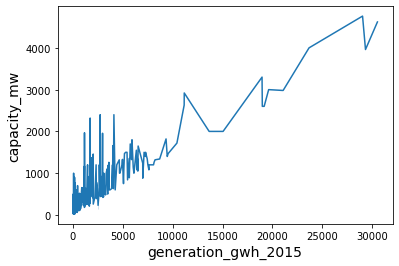

In [178]:
#visualize this column by lineplot
sns.lineplot(x= 'generation_gwh_2015', y = 'capacity_mw', data=df)
plt.xlabel('generation_gwh_2015', fontsize = 14)
plt.ylabel('capacity_mw', fontsize = 14)

Text(0, 0.5, 'primary_fuel')

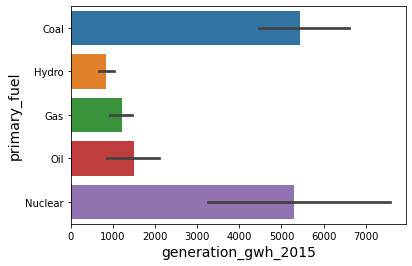

In [179]:
#visualize this column by barplot
sns.barplot(x= 'generation_gwh_2015', y = 'primary_fuel', data=df)
plt.xlabel('generation_gwh_2015', fontsize = 14)
plt.ylabel('primary_fuel', fontsize = 14)

observation:
1. Zero values and Null values are not found
2. We can see, the highest capacity power plant '4760.0' have 29047.0 generation in ghw in 2015

In [180]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (324, 14)


# Column19: generation_gwh_2016

In [181]:
df['generation_gwh_2016'].unique() #check the unique values

array([6.24300000e+03, 1.17576500e+03, 6.75724400e+02, 4.02029750e+02,
       1.33809300e+03, 1.70100800e+03, 6.70500650e+02, 7.90202160e+03,
       1.32273523e+04, 6.66420000e+02, 5.09000000e+02, 2.83200000e+02,
       0.00000000e+00, 1.51100000e+03, 2.17363720e+03, 6.65983350e+02,
       9.96373100e+02, 1.23282490e+03, 1.09181350e+02, 5.32126000e+01,
       6.77378800e+03, 4.43242650e+02, 3.54900000e+02, 1.27499900e+03,
       1.04689800e+01, 1.33603625e+03, 2.96271200e+02, 5.99932000e+03,
       2.69247000e+01, 5.14242865e+03, 4.68844000e+01, 1.97308500e+01,
       1.73826500e+01, 2.04870500e+01, 3.37910050e+03, 9.46871850e+02,
       1.01072100e+02, 2.05557050e+02, 5.66607190e+03, 7.39155400e+02,
       5.11710000e+00, 2.59943750e+02, 3.44980000e+03, 4.33848000e+02,
       1.43671035e+03, 2.21326805e+03, 9.12504550e+02, 1.36754400e+04,
       8.16317900e+01, 6.13378400e+03, 7.10430000e+02, 7.65503250e+02,
       4.38994000e+01, 8.19700000e+03, 2.17800000e+03, 3.16875660e+03,
      

In [182]:
df['generation_gwh_2016'].value_counts() # check the counts of unique values

0.000000       25
8655.446996     1
6133.784000     1
306.012250      1
3449.800000     1
               ..
2.970000        1
1701.008000     1
81.631790       1
446.536100      1
1436.710350     1
Name: generation_gwh_2016, Length: 300, dtype: int64

In [183]:
df['generation_gwh_2016'].all() #check the zero values

False

In [184]:
#replace the zero values by mean values
df['generation_gwh_2016'] = df['generation_gwh_2016'].replace(0.0, df['generation_gwh_2016'].mean())

In [185]:
df['generation_gwh_2016'].all() #check the zero values

True

In [186]:
df['generation_gwh_2016'].isnull().sum()

0

In [187]:
#check the relationship between capacity_mw and generation_gwh_2016
df.groupby('capacity_mw')['generation_gwh_2016'].value_counts().sort_index(ascending=True).tail(1)

capacity_mw  generation_gwh_2016
4760.0       30015.0                1
Name: generation_gwh_2016, dtype: int64

Text(0, 0.5, 'capacity_mw')

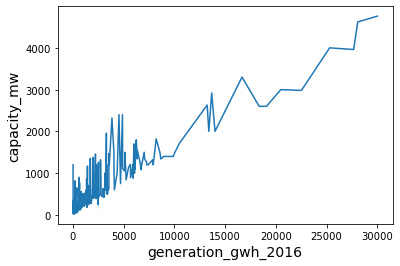

In [188]:
#visualize this column by lineplot
sns.lineplot(x= 'generation_gwh_2016', y = 'capacity_mw', data=df)
plt.xlabel('generation_gwh_2016', fontsize = 14)
plt.ylabel('capacity_mw', fontsize = 14)

Text(0, 0.5, 'primary_fuel')

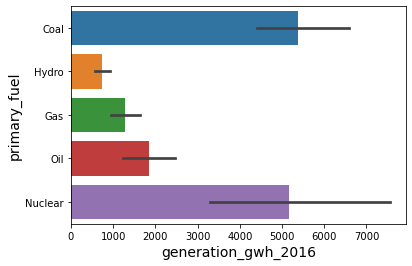

In [189]:
#visualize this column by Barplot
sns.barplot(x= 'generation_gwh_2016', y = 'primary_fuel', data=df)
plt.xlabel('generation_gwh_2016', fontsize = 14)
plt.ylabel('primary_fuel', fontsize = 14)

observation:
1. Zero values and Null values are not found
2. We can see, the highest capacity power plant '4760.0' have 30015.0 generation in ghw in 2016

In [190]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (324, 14)


# Column20: generation_gwh_2017

In [191]:
df['generation_gwh_2017'].unique() #check the unique values

array([5.38557974e+03, 1.14791300e+03, 6.79594950e+02, 4.39372100e+02,
       1.56345700e+03, 4.35055800e+03, 6.44570950e+02, 7.94074000e+03,
       1.53348763e+04, 4.30000000e+02, 3.57000000e+02, 5.40290000e+02,
       0.00000000e+00, 1.39500000e+03, 2.49417645e+03, 6.38521350e+02,
       1.46980405e+03, 5.42643150e+02, 5.58394000e+01, 6.84560000e+01,
       6.15376000e+03, 1.58254750e+02, 1.71355000e+02, 1.43607200e+03,
       5.85771000e+00, 1.32996675e+03, 3.13594150e+02, 3.73840000e+03,
       1.56115500e+01, 5.10834990e+03, 4.23372500e+01, 3.74319000e+01,
       1.68752000e+01, 3.59090000e+03, 8.87838500e+02, 9.66642500e+01,
       3.05664000e+02, 6.15962100e+03, 2.26547000e+03, 4.25768796e-01,
       6.07180000e+01, 3.16041850e+02, 3.03264960e+03, 4.20909000e+02,
       1.47967445e+03, 2.33235960e+03, 1.06270975e+03, 1.37802300e+04,
       8.26556450e+01, 6.87063795e+03, 7.79652150e+02, 8.07601700e+02,
       4.54914000e+01, 9.27100000e+03, 1.57500000e+03, 3.07080880e+03,
      

In [192]:
df['generation_gwh_2017'].value_counts() # check the counts of unique values

0.00000       24
170.08530      2
7006.79130     1
307.37540      1
6992.78000     1
              ..
9271.00000     1
15.61155       1
7090.90000     1
85.03270       1
158.73235      1
Name: generation_gwh_2017, Length: 294, dtype: int64

In [193]:
df['generation_gwh_2017'].all() #check the zeros

False

In [194]:
#replace the zero values by mean values
df['generation_gwh_2017'] = df['generation_gwh_2017'].replace(0.0, df['generation_gwh_2017'].mean())

In [195]:
df['generation_gwh_2017'].all()#check the zeros 

True

In [196]:
df['generation_gwh_2017'].isnull().sum()

6

In [197]:
df.dropna(subset=["generation_gwh_2017"], inplace=True) #drop the null values

In [198]:
df['generation_gwh_2017'].isnull().sum()

0

In [199]:
#check the relationship between capacity_mw and generation_gwh_2017
df.groupby('capacity_mw')['generation_gwh_2017'].value_counts().sort_index(ascending=True).tail(1)

capacity_mw  generation_gwh_2017
4760.0       35116.0                1
Name: generation_gwh_2017, dtype: int64

Text(0, 0.5, 'capacity_mw')

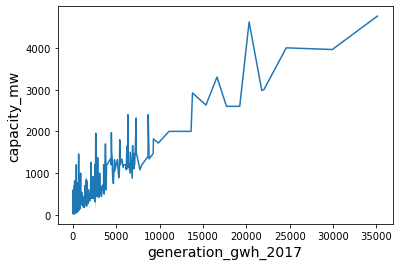

In [200]:
#visualize this column by lineplot
sns.lineplot(x= 'generation_gwh_2017', y = 'capacity_mw', data=df)
plt.xlabel('generation_gwh_2017', fontsize = 14)
plt.ylabel('capacity_mw', fontsize = 14)

Text(0, 0.5, 'primary_fuel')

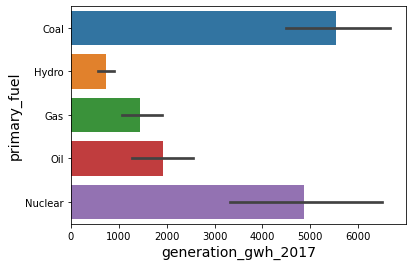

In [201]:
#visualize this column by Barplot
sns.barplot(x= 'generation_gwh_2017', y = 'primary_fuel', data=df)
plt.xlabel('generation_gwh_2017', fontsize = 14)
plt.ylabel('primary_fuel', fontsize = 14)

In [202]:
t = df.groupby(["generation_gwh_2013", "generation_gwh_2014","generation_gwh_2015","generation_gwh_2016","generation_gwh_2017"])['primary_fuel'].sum()

In [203]:
t

generation_gwh_2013  generation_gwh_2014  generation_gwh_2015  generation_gwh_2016  generation_gwh_2017
0.019900             1310.98215           1973.492950          1950.61790           2004.92500             Hydro
0.821705             2.85387              8.295912             10.46898             5.85771                  Gas
2.275700             265.78000            2316.107200          6773.78800           6153.76000              Coal
3.308800             373.91900            417.168000           433.84800            420.90900               Coal
4.756100             657.47610            639.785000           679.06760            706.97735              Hydro
                                                                                                           ...  
18560.000000         19224.00000          18990.000000         18357.00000          17704.00000             Coal
19353.000000         18807.00000          19176.000000         19078.00000          19229.00000          

observation:
1. Zero values and Null values are not found
2. We can see, the highest capacity power plant '4760.0' have 35116.0 generation in ghw in 2017
3. We can say, the generation is improving year by year of highest capacity power plant '4760.0'

In [204]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (318, 14)


# Column21: generation_data_source

In [205]:
df['generation_data_source'].unique() #check the unique values

array(['Central Electricity Authority'], dtype=object)

In [206]:
df['generation_data_source'].value_counts() # check the counts of unique values

Central Electricity Authority    318
Name: generation_data_source, dtype: int64

In [207]:
df.drop(columns = ['generation_data_source'], inplace = True) #drop the column

In [208]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (318, 13)


# Column22: estimated_generation_gwh

In [209]:
df['estimated_generation_gwh'].unique() #check the unique values

array([nan])

In [210]:
df['estimated_generation_gwh'].value_counts() # check the counts of unique values

Series([], Name: estimated_generation_gwh, dtype: int64)

In [211]:
df.drop(columns = ['estimated_generation_gwh'], inplace = True) #drop the column

In [212]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (318, 12)


In [213]:
df.drop(columns = ['name'], inplace = True) #drop the column
df.drop(columns = ['source'], inplace = True) 

# Label1: Primary_fuel

In [214]:
df['primary_fuel'].unique() #check the unique values

array(['Coal', 'Hydro', 'Gas', 'Oil', 'Nuclear'], dtype=object)

In [215]:
df['primary_fuel'].value_counts() #check the counts of unique values

Hydro      141
Coal       120
Gas         43
Oil          8
Nuclear      6
Name: primary_fuel, dtype: int64

In [216]:
df['primary_fuel'].isnull().sum() #check for null values

0

In [217]:
#convert string into integer
df['primary_fuel'] = df['primary_fuel'].map({'Hydro':0, 'Coal':1, 'Gas': 2, 'Oil':3, 'Nuclear':4})

In [218]:
df['primary_fuel'].unique() #check the unique values

array([1, 0, 2, 3, 4], dtype=int64)

In [219]:
df['primary_fuel'].value_counts() #check the counts of unique values

0    141
1    120
2     43
3      8
4      6
Name: primary_fuel, dtype: int64

In [220]:
#check the updated shape of our dataset
print('Actual shape of our Dataset now :-------->', df.shape)

Actual shape of our Dataset now :--------> (318, 10)


# Label2: capacity_mw

In [221]:
df['capacity_mw'].unique() #check the unique values

array([1800.   ,  250.   ,  192.   ,  290.   ,  210.   , 1350.   ,
        134.   , 1200.   , 2630.   ,  419.33 ,  652.   ,  600.   ,
        200.   ,  705.   ,  450.   ,  180.   ,  510.   ,  315.   ,
         30.   ,   60.   ,   90.   ,  120.   ,  300.   ,   64.   ,
         25.2  , 1700.   ,   39.2  , 1325.   ,   34.   ,  500.   ,
         80.   ,   75.   , 1210.   ,  165.   ,   70.   ,  540.   ,
        231.   , 2920.   ,   32.8  , 1660.   ,  240.   ,  144.   ,
         44.   , 1820.   ,  816.4  ,  990.   ,   33.75 ,   51.   ,
        280.   ,  330.   ,  595.2  ,  390.   ,  515.   ,  431.586,
        310.   ,  648.   ,  630.   ,  115.   ,   77.65 ,  468.57 ,
         32.   ,  920.   ,  440.   ,  205.24 ,  156.1  ,  351.43 ,
        605.   ,  270.   ,  780.   , 1000.   , 1500.   ,   99.   ,
       1080.   ,  445.674,  139.2  ,  400.   ,  150.   ,  880.   ,
       1100.   ,   50.   ,  855.   ,  100.   ,   32.5  ,  119.8  ,
         35.   , 1320.   ,  645.   ,  350.   ,   72.   ,   41.

In [222]:
df['capacity_mw'].value_counts() #check the counts of unique values

600.0     13
1200.0    11
500.0      9
300.0      8
120.0      8
          ..
231.0      1
648.0      1
1330.0     1
2320.0     1
2980.0     1
Name: capacity_mw, Length: 190, dtype: int64

In [223]:
df['capacity_mw'].isnull().sum()

0

Text(0, 0.5, 'primary_fuel')

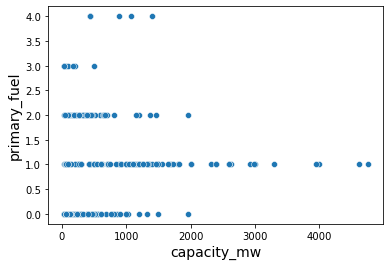

In [224]:
#visualize this column by Barplot
sns.scatterplot(x= 'capacity_mw', y = 'primary_fuel', data=df)
plt.xlabel('capacity_mw', fontsize = 14)
plt.ylabel('primary_fuel', fontsize = 14)

correlation between the Features and with label:-----> (10, 10)

 **************************************************


<function matplotlib.pyplot.show(close=None, block=None)>

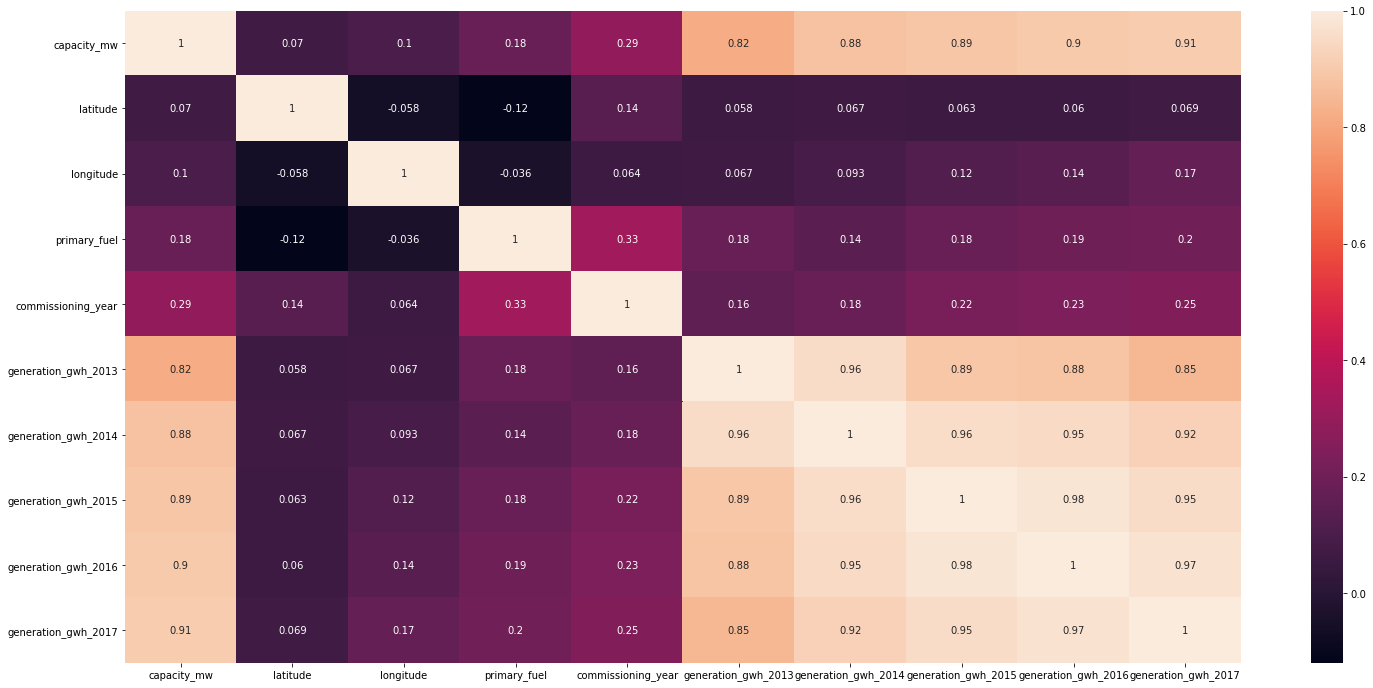

In [225]:
# Check the correlation 
corr = df.corr()
print('correlation between the Features and with label:----->',corr.shape)
print("\n",'*'*50)
# Visualize the corrrelation by using heatmap
plt.figure(figsize=(25,12))
sns.heatmap(corr, annot=True)
plt.show 

In [226]:
df.drop(columns= ['generation_gwh_2013'], inplace = True) #drop the highly corelated columns
df.drop(columns= ['generation_gwh_2014'], inplace = True)
df.drop(columns= ['generation_gwh_2015'], inplace = True)
df.drop(columns= ['generation_gwh_2016'], inplace = True)

correlation between the Features and with label:-----> (6, 6)

 **************************************************


<function matplotlib.pyplot.show(close=None, block=None)>

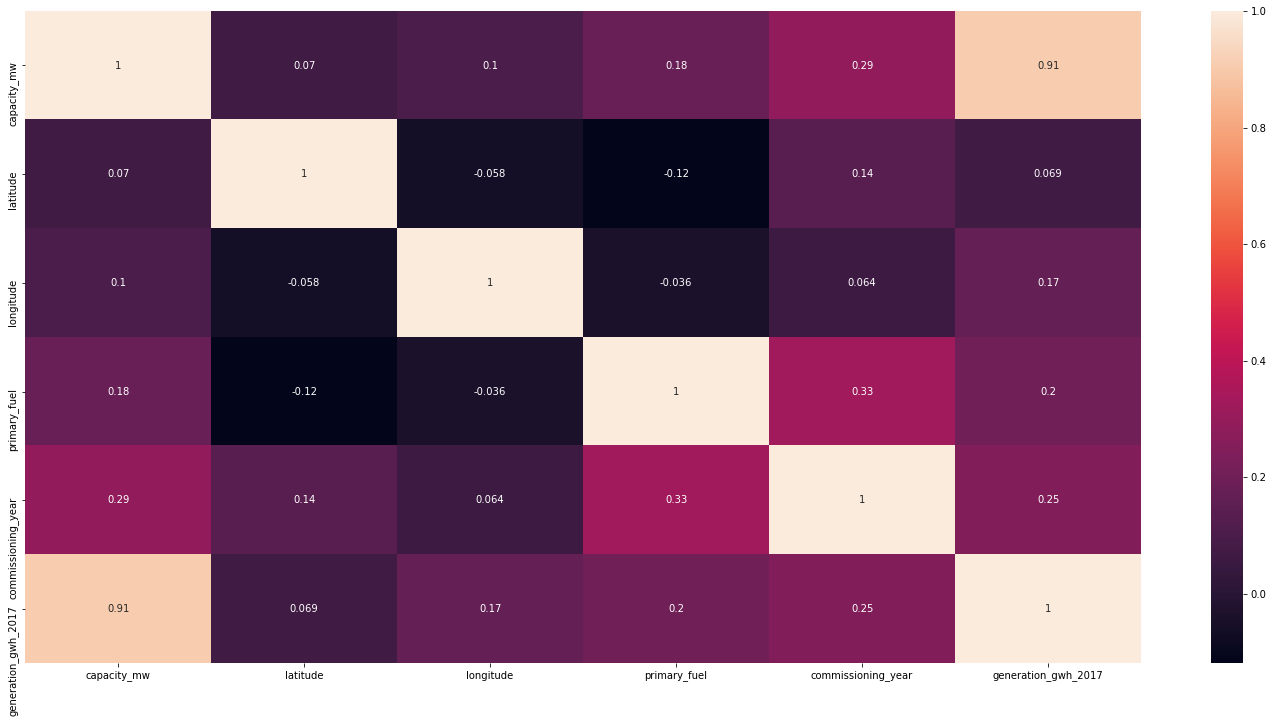

In [227]:
# Check the correlation 
corr = df.corr()
print('correlation between the Features and with label:----->',corr.shape)
print("\n",'*'*50)
# Visualize the corrrelation by using heatmap
plt.figure(figsize=(25,12))
sns.heatmap(corr, annot=True)
plt.show 

In [228]:
#split x and y
x = df.drop(['primary_fuel'], axis=1)
y=df.primary_fuel

In [229]:
#scale the value x
Scaler = StandardScaler()
x_scaled = Scaler.fit_transform(x)
x_scaled

array([[ 1.5874205 ,  0.08559897,  1.59159269,  1.20193228,  0.59764843],
       [-0.48625691,  0.34019883, -2.80532908,  0.595916  , -0.36322289],
       [-0.56385258,  1.53069176, -0.07017439,  0.89892414, -0.46941184],
       ...,
       [-0.09827856, -0.1519675 ,  0.49593999,  0.89892414, -0.39694968],
       [-0.73723877,  1.260058  ,  0.0452718 , -0.25250678, -0.58363   ],
       [-0.01800717,  1.23257935, -0.03225667,  0.71711926,  0.09211371]])

In [230]:
# Check the multicollinearity between the features
#import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["vif"]= [ variance_inflation_factor(x_scaled, i)
               for i in range ( x_scaled.shape[1])]
vif['features']= x.columns
vif 

,vif,features
0,5.880184,capacity_mw
1,1.027942,latitude
2,1.056938,longitude
3,1.114187,commissioning_year
4,5.853156,generation_gwh_2017


In [231]:
#split data into train and test.
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y,test_size = 0.25, random_state=42)

In [232]:
y_train.head()

450    1
170    0
336    2
11     0
570    3
Name: primary_fuel, dtype: int64

# Check the Accuracy by using 5 classification models

In [233]:
log_reg = LogisticRegression() #Model instantiating
dt = DecisionTreeClassifier()
rf= RandomForestClassifier()
knn = KNeighborsClassifier()
svc = SVC()

In [234]:
#train the model
log_reg.fit(x_train,y_train)
dt.fit(x_train,y_train)
rf.fit(x_train,y_train)
knn.fit(x_train,y_train)
svc.fit(x_train,y_train)
print("all models are trained")

all models are trained


In [235]:
log_reg.score(x_test,y_test) #Let's check how well model fits the test data
dt.score(x_test,y_test)
rf.score(x_test,y_test)
knn.score(x_test,y_test)
svc.score(x_test,y_test)
print("all models score are captured")

all models score are captured


In [236]:
y_pred_log_reg = log_reg.predict(x_test) #save the predictions in some variables
y_pred_dt = dt.predict(x_test) 
y_pred_rf = rf.predict(x_test) 
y_pred_knn = knn.predict(x_test) 
y_pred_svc = svc.predict(x_test) 

In [237]:
#check the accuracy score, confusion matrix and classification report
print('Accuracy_score of Logistic regression:-------->  ',accuracy_score(y_test,y_pred_log_reg))
time.sleep(2)
print('Confusion_matrix:\n' , confusion_matrix(y_test,y_pred_log_reg))
time.sleep(2)
print('Classification_report:\n' , classification_report(y_test,y_pred_log_reg))

time.sleep(2)
print("\n",'*'*50)
print("\n",'*'*50)
time.sleep(2)


print('Accuracy_score of Decision Tree:-------->  ',accuracy_score(y_test,y_pred_dt))
time.sleep(2)
print('Confusion_matrix:\n' , confusion_matrix(y_test,y_pred_dt))
time.sleep(2)
print('Classification_report:\n' , classification_report(y_test,y_pred_dt))

time.sleep(2)
print("\n",'*'*50)
print("\n",'*'*50)
time.sleep(2)

print('Accuracy_score of Random forest:-------->  ',accuracy_score(y_test,y_pred_rf))
time.sleep(2)
print('Confusion_matrix:\n' , confusion_matrix(y_test,y_pred_rf))
time.sleep(2)
print('Classification_report:\n' , classification_report(y_test,y_pred_rf))

time.sleep(2)
print("\n",'*'*50)
print("\n",'*'*50)
time.sleep(2)

print('Accuracy_score of KNeighbors Classifiers:-------->  ',accuracy_score(y_test,y_pred_knn))
time.sleep(2)
print('Confusion_matrix:\n' , confusion_matrix(y_test,y_pred_knn))
time.sleep(2)
print('Classification_report:\n' , classification_report(y_test,y_pred_knn))

time.sleep(2)
print("\n",'*'*50)
print("\n",'*'*50)
time.sleep(2)

print('Accuracy_score of Support Vector Machine:-------->  ',accuracy_score(y_test,y_pred_svc))
time.sleep(2)
print('Confusion_matrix:\n' , confusion_matrix(y_test,y_pred_svc))
time.sleep(2)
print('Classification_report:\n' , classification_report(y_test,y_pred_svc))

Accuracy_score of Logistic regression:-------->   0.6625
Confusion_matrix:
 [[33  6  0  0]
 [ 9 19  0  0]
 [ 7  3  1  0]
 [ 1  1  0  0]]
Classification_report:
               precision    recall  f1-score   support

           0       0.66      0.85      0.74        39
           1       0.66      0.68      0.67        28
           2       1.00      0.09      0.17        11
           4       0.00      0.00      0.00         2

    accuracy                           0.66        80
   macro avg       0.58      0.40      0.39        80
weighted avg       0.69      0.66      0.62        80


 **************************************************

 **************************************************
Accuracy_score of Decision Tree:-------->   0.7875
Confusion_matrix:
 [[34  3  1  1  0]
 [ 3 21  2  2  0]
 [ 2  1  8  0  0]
 [ 0  0  0  0  0]
 [ 0  1  1  0  0]]
Classification_report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        39
    

In [238]:
#check all model cv score
print("Logistic regression CV Score:")
print(cross_val_score(log_reg,x_scaled,y,cv=5))

time.sleep(2)
print("\n",'*'*50)

print("Decision Tree CV Score:")
print(cross_val_score(dt,x_scaled,y,cv=5))

time.sleep(2)
print("\n",'*'*50)

print("Random Forest CV Score:")
print(cross_val_score(rf,x_scaled,y,cv=5))

time.sleep(2)
print("\n",'*'*50)

print("KNeighbour Classifier CV Score:")
print(cross_val_score(knn,x_scaled,y,cv=5))

time.sleep(2)
print("\n",'*'*50)

print("Support Vector Machine CV Score:")
print(cross_val_score(svc,x_scaled,y,cv=5))

Logistic regression CV Score:
[0.703125   0.703125   0.671875   0.74603175 0.71428571]

 **************************************************
Decision Tree CV Score:
[0.78125    0.71875    0.625      0.74603175 0.6984127 ]

 **************************************************
Random Forest CV Score:
[0.75       0.796875   0.796875   0.80952381 0.79365079]

 **************************************************
KNeighbour Classifier CV Score:
[0.703125   0.828125   0.75       0.74603175 0.74603175]

 **************************************************
Support Vector Machine CV Score:
[0.75       0.734375   0.671875   0.76190476 0.80952381]


In [239]:
#Check the mean of all models cv score one by one
print("Logistic regression CV Score:")
print(cross_val_score(log_reg,x_scaled,y,cv=5).mean())

time.sleep(2)
print("\n",'*'*50)

print("Decision Tree CV Score:")
print(cross_val_score(dt,x_scaled,y,cv=5).mean())

time.sleep(2)
print("\n",'*'*50)

print("Random Forest CV Score:")
print(cross_val_score(rf,x_scaled,y,cv=5).mean())

time.sleep(2)
print("\n",'*'*50)

print("KNeighbour Classifier CV Score:")
print(cross_val_score(knn,x_scaled,y,cv=5).mean())

time.sleep(2)
print("\n",'*'*50)

print("Support Vector Machine CV Score:")
print(cross_val_score(svc,x_scaled,y,cv=5).mean())

Logistic regression CV Score:
0.707688492063492

 **************************************************
Decision Tree CV Score:
0.7013392857142857

 **************************************************
Random Forest CV Score:
0.7862103174603174

 **************************************************
KNeighbour Classifier CV Score:
0.7546626984126984

 **************************************************
Support Vector Machine CV Score:
0.7455357142857142


# GridSearchCV By using Knn as a estimator

In [242]:
param_grid = {'algorithm':['kdtree','brute'], 'leaf_size':[12,11,14,15,18,20,25], 'n_neighbors':[3,5,7,9,11,13]}
gridsearch = GridSearchCV(estimator=knn, param_grid= param_grid) #apply GridSearchCV
time.sleep(2)
print(gridsearch.fit(x_train,y_train)) #train the model
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('GridSearchCV best parameters:----->',gridsearch.best_params_) #get best parameters
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
#put best params into knn
knn1 = gridsearch.best_estimator_ #save that best param into one variable
print('Trained Model using best parameters:----->',knn1.fit(x_train,y_train))#train the model
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('Accuracy score:------>',knn1.score(x_train,y_train)) #check the accuracy score

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['kdtree', 'brute'],
                         'leaf_size': [12, 11, 14, 15, 18, 20, 25],
                         'n_neighbors': [3, 5, 7, 9, 11, 13]})

 **************************************************
GridSearchCV best parameters:-----> {'algorithm': 'brute', 'leaf_size': 12, 'n_neighbors': 3}

 **************************************************
Trained Model using best parameters:-----> KNeighborsClassifier(algorithm='brute', leaf_size=12, n_neighbors=3)

 **************************************************
Accuracy score:------> 0.8613445378151261


# GridSearchCV By using SVC as a estimator

In [243]:
param_grid = {'C': [1,2,4,5,6,7,8,9,10],         
             'gamma': [0.2,0.3,0.4,0.5,0.6,0.7,0.8],
             'kernel': ['rbf']}
gridsearch = GridSearchCV(estimator=svc, param_grid= param_grid)#apply GridSearchCV
time.sleep(2)
print(gridsearch.fit(x_train,y_train)) #train the model
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('GridSearchCV best parameters:----->',gridsearch.best_params_) #get best parameters
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
#put best params into svc
svc1 = gridsearch.best_estimator_#save that best param into one variable
print('Trained Model using best parameters:----->',svc1.fit(x_train,y_train))#train the model
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('Accuracy score:------>',svc1.score(x_train,y_train))#check the accuracy score

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 2, 4, 5, 6, 7, 8, 9, 10],
                         'gamma': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                         'kernel': ['rbf']})

 **************************************************
GridSearchCV best parameters:-----> {'C': 2, 'gamma': 0.5, 'kernel': 'rbf'}

 **************************************************
Trained Model using best parameters:-----> SVC(C=2, gamma=0.5)

 **************************************************
Accuracy score:------> 0.8949579831932774


# GridSearchCV By using RandomForestClassifier as a estimator

In [244]:
params = {'n_estimators':[13,15],
         'criterion':['entropy'],
         'max_depth':[10,15],
         'min_samples_split':[10,11],
         'min_samples_leaf':[5,6]}
gridsearch = GridSearchCV(estimator=rf, param_grid= params)#apply GridSearchCV
time.sleep(2)
print(gridsearch.fit(x_train,y_train)) #train the model
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('GridSearchCV best parameters:----->',gridsearch.best_params_) #get best parameters
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
#put best params into knn
rfc = gridsearch.best_estimator_
print('Trained Model using best parameters:----->',rfc.fit(x_train,y_train)) #train the model
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('Accuracy score:------>',rfc.score(x_train,y_train))#check the accuracy score

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': [10, 15],
                         'min_samples_leaf': [5, 6],
                         'min_samples_split': [10, 11],
                         'n_estimators': [13, 15]})

 **************************************************
GridSearchCV best parameters:-----> {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 13}

 **************************************************
Trained Model using best parameters:-----> RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=13)

 **************************************************
Accuracy score:------> 0.8823529411764706


# GridSearchCV By using DecisionTreeClassifier as a estimator

In [245]:
params = {'criterion':['entropy','gini'],
         'max_depth':range(10,15),
         'min_samples_split':[3,10],
         'min_samples_leaf':[2,10]}
gridsearch = GridSearchCV(estimator=dt, param_grid= params)#apply GridSearchCV
time.sleep(2)
print(gridsearch.fit(x_train,y_train)) #train the model
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('GridSearchCV best parameters:----->',gridsearch.best_params_) #get best parameters
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
#put best params into knn
dtr = gridsearch.best_estimator_
print('Trained Model using best parameters:----->',dtr.fit(x_train,y_train))#train the model
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('Accuracy score:------>',dtr.score(x_train,y_train))#check the accuracy score

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(10, 15),
                         'min_samples_leaf': [2, 10],
                         'min_samples_split': [3, 10]})

 **************************************************
GridSearchCV best parameters:-----> {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 3}

 **************************************************
Trained Model using best parameters:-----> DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=2,
                       min_samples_split=3)

 **************************************************
Accuracy score:------> 0.9495798319327731


# Bagging Classifier with Bootstrap = True (Using 4 models)

Using knn as a best estimator

In [255]:
bag_knn = BaggingClassifier(KNeighborsClassifier(n_neighbors=5),
                           n_estimators=10, max_samples=0.5,
                           bootstrap=True, random_state=5,
                           oob_score=False)
time.sleep(2)
print('Model is Trained:- ', bag_knn.fit(x_train,y_train))
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('Accuracy score by using BaggingClassifier:-', bag_knn.score(x_test,y_test))

Model is Trained:-  BaggingClassifier(base_estimator=KNeighborsClassifier(), max_samples=0.5,
                  random_state=5)

 **************************************************
Accuracy score by using BaggingClassifier:- 0.725


Using svc as a best estimator

In [247]:
bag_svc = BaggingClassifier(SVC(),                       #using svc as a best estimator
                           n_estimators=15,
                           bootstrap=True, random_state=5,
                           oob_score=True)
time.sleep(2)
print('Model is Trained:- ', bag_svc.fit(x_train,y_train))
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('Accuracy score by using BaggingClassifier:-', bag_svc.score(x_test,y_test))

Model is Trained:-  BaggingClassifier(base_estimator=SVC(), n_estimators=15, oob_score=True,
                  random_state=5)

 **************************************************
Accuracy score by using BaggingClassifier:- 0.675


Using RandomForestClassifier as a best estimator

In [248]:
bag_rf = BaggingClassifier(RandomForestClassifier(),#using RandomForest as a best estimator
                           n_estimators=15,
                           bootstrap=True, random_state=7,
                           oob_score=True)
time.sleep(2)
print('Model is Trained:- ', bag_rf.fit(x_train,y_train))
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('Accuracy score by using BaggingClassifier:-', bag_rf.score(x_test,y_test))

Model is Trained:-  BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=15,
                  oob_score=True, random_state=7)

 **************************************************
Accuracy score by using BaggingClassifier:- 0.7375


Using DecisionTreeClassifier as a best estimator

In [249]:
bag_dt = BaggingClassifier(dt,                        #using DecisionTree as a best estimator
                           n_estimators=15,
                           bootstrap=True, random_state=7,
                           oob_score=True)
time.sleep(2)
print('Model is Trained:- ', bag_dt.fit(x_train,y_train))
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('Accuracy score by using BaggingClassifier:-', bag_dt.score(x_test,y_test))

Model is Trained:-  BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=15,
                  oob_score=True, random_state=7)

 **************************************************
Accuracy score by using BaggingClassifier:- 0.7625


# Bagging Classifier with Bootstrap = False (Using 4 models)

Using knn as a best estimator

In [250]:
bag_knn = BaggingClassifier(KNeighborsClassifier(n_neighbors=5),#using knn as a best estimator
                           n_estimators=10, max_samples=0.5,
                           bootstrap=False, random_state=3,
                           )
time.sleep(2)
print('Model is Trained:- ', bag_knn.fit(x_train,y_train))
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('Accuracy score by using BaggingClassifier:-', bag_knn.score(x_test,y_test))

Model is Trained:-  BaggingClassifier(base_estimator=KNeighborsClassifier(), bootstrap=False,
                  max_samples=0.5, random_state=3)

 **************************************************
Accuracy score by using BaggingClassifier:- 0.725


Using svc as a best estimator

In [251]:
bag_svc = BaggingClassifier(SVC(),                  #using svc as a best estimator
                           n_estimators=15,
                           bootstrap=False, random_state=5,
                           )
time.sleep(2)
print('Model is Trained:- ', bag_svc.fit(x_train,y_train))
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('Accuracy score by using BaggingClassifier:-', bag_svc.score(x_test,y_test))

Model is Trained:-  BaggingClassifier(base_estimator=SVC(), bootstrap=False, n_estimators=15,
                  random_state=5)

 **************************************************
Accuracy score by using BaggingClassifier:- 0.7


Using RandomForestClassifier as a best estimator

In [252]:
bag_rf = BaggingClassifier(RandomForestClassifier(),   #using RandomForest as a best estimator
                           n_estimators=15,
                           bootstrap=False, random_state=7,
                           )
time.sleep(2)
print('Model is Trained:- ', bag_rf.fit(x_train,y_train))
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('Accuracy score by using BaggingClassifier:-', bag_rf.score(x_test,y_test))

Model is Trained:-  BaggingClassifier(base_estimator=RandomForestClassifier(), bootstrap=False,
                  n_estimators=15, random_state=7)

 **************************************************
Accuracy score by using BaggingClassifier:- 0.725


Using DecisionTreeClassifier as a best estimator

In [253]:
bag_dt = BaggingClassifier(dt,                       #using DecisionTree as a best estimator
                           n_estimators=15,
                           bootstrap=False, random_state=7,
                           )
time.sleep(2)
print('Model is Trained:- ', bag_dt.fit(x_train,y_train))
time.sleep(1)
print("\n",'*'*50)
time.sleep(1)
print('Accuracy score by using BaggingClassifier:-', bag_dt.score(x_test,y_test))

Model is Trained:-  BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=False,
                  n_estimators=15, random_state=7)

 **************************************************
Accuracy score by using BaggingClassifier:- 0.8125


In [256]:
df.columns

Index(['capacity_mw', 'latitude', 'longitude', 'primary_fuel',
       'commissioning_year', 'generation_gwh_2017'],
      dtype='object')

In [257]:
#split x and y
x = df.drop(['capacity_mw'], axis=1)
y=df.capacity_mw

In [258]:
#scale the value x
Scaler = StandardScaler()
x_scaled = Scaler.fit_transform(x)
x_scaled

array([[ 0.08559897,  1.59159269,  0.22382001,  1.20193228,  0.59764843],
       [ 0.34019883, -2.80532908,  0.22382001,  0.595916  , -0.36322289],
       [ 1.53069176, -0.07017439, -0.88828566,  0.89892414, -0.46941184],
       ...,
       [-0.1519675 ,  0.49593999,  0.22382001,  0.89892414, -0.39694968],
       [ 1.260058  ,  0.0452718 , -0.88828566, -0.25250678, -0.58363   ],
       [ 1.23257935, -0.03225667,  0.22382001,  0.71711926,  0.09211371]])

In [259]:
# Check the multicollinearity between the features
#import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["vif"]= [ variance_inflation_factor(x_scaled, i)
               for i in range ( x_scaled.shape[1])]
vif['features']= x.columns
vif 

,vif,features
0,1.066719,latitude
1,1.047545,longitude
2,1.191891,primary_fuel
3,1.207718,commissioning_year
4,1.122812,generation_gwh_2017


In [260]:
#split data into train and test.
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y,test_size = 0.25, random_state=42)

In [261]:
y_train.head()

450    1320.00
170      33.75
336     645.00
11      134.00
570     175.00
Name: capacity_mw, dtype: float64

# Linear regression

In [290]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor #import library
from sklearn import metrics

In [279]:
#Model instantiating and training
lr = LinearRegression()
dtr=DecisionTreeRegressor()
rfo = RandomForestRegressor()

In [282]:
print('Linear Regression',lr.fit(x_train, y_train))
time.sleep(2)
print('Decsion Tree',dtr.fit(x_train, y_train))
time.sleep(2)
print('Random Forest',rfo.fit(x_train, y_train))

Linear Regression LinearRegression()
Decsion Tree DecisionTreeRegressor()
Random Forest RandomForestRegressor()


In [284]:
#Check How much our model learn
print('Linear regression Score:-------->', lr.score(x_train, y_train))
time.sleep(2)
print('Decision Tree score:------->', dtr.score(x_train,y_train))
time.sleep(2)
print('Random Forest score:------>',rfo.score(x_train, y_train))

Linear regression Score:--------> 0.8485916213051886
Decision Tree score:-------> 0.9999995521090058
Random Forest score:------> 0.9765566147811714


In [286]:
#Let's check how well model fits the test data
print('Linear regression Score:-------->', lr.score(x_test, y_test))
time.sleep(2)
print('Decision Tree score:------->', dtr.score(x_test,y_test))
time.sleep(2)
print('Random Forest score:------>',rfo.score(x_test, y_test))

Linear regression Score:--------> 0.7224499620460401
Decision Tree score:-------> 0.3402183788078318
Random Forest score:------> 0.6955739793473408


In [287]:
y_pred_lr = lr.predict(x_test)#save the predictions in some variables
y_pred_dtr = dtr.predict(x_test)
y_pred_rfo = rfo.predict(x_test)

Linear Regression


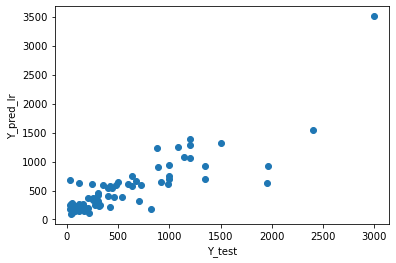

Decision Tree


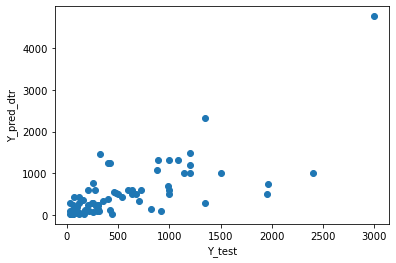

Random Forest


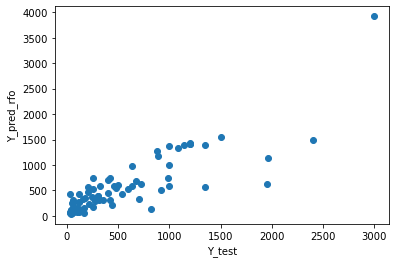

In [288]:
#plot the actual and predicted value
print("Linear Regression:")
plt.scatter(y_test,y_pred_lr)
plt.xlabel('Y_test')
plt.ylabel('Y_pred_lr')
plt.show()
time.sleep(2)
print("Decision Tree:")
plt.scatter(y_test,y_pred_dtr)
plt.xlabel('Y_test')
plt.ylabel('Y_pred_dtr')
plt.show()
time.sleep(2)
print("Random Forest:")
plt.scatter(y_test,y_pred_rfo)
plt.xlabel('Y_test')
plt.ylabel('Y_pred_rfo')
plt.show()

In [291]:
#calculate Mean absolute error
print("Linear Regression:")
print('MAE:--------->',mean_absolute_error(y_test, y_pred_lr))#calculate Mean absolute error
time.sleep(1)
print('MSE:----------->',mean_squared_error(y_test,y_pred_lr))#calculate mean squared error
time.sleep(1)
print('RSME:--------->',np.sqrt(mean_squared_error(y_test,y_pred_lr)))#calculate root mean square error

time.sleep(2)
print("Decision Tree:")
print('MAE:--------->',mean_absolute_error(y_test, y_pred_dtr))#calculate Mean absolute error
time.sleep(1)
print('MSE:----------->',mean_squared_error(y_test,y_pred_dtr))#calculate mean squared error
time.sleep(1)
print('RSME:--------->',np.sqrt(mean_squared_error(y_test,y_pred_dtr)))#calculate root mean square error
time.sleep(2)
print("Random Forest:")
print('MAE:--------->',mean_absolute_error(y_test, y_pred_rfo))#calculate Mean absolute error
time.sleep(1)
print('MSE:----------->',mean_squared_error(y_test,y_pred_rfo))#calculate mean squared error
time.sleep(1)
print('RSME:--------->',np.sqrt(mean_squared_error(y_test,y_pred_rfo)))#calculate root mean square error

Linear Regression:
MAE:---------> 199.84464121239597
MSE:-----------> 91982.4550741229
RSME:---------> 303.28609442920873
Decision Tree:
MAE:---------> 279.3440875
MSE:-----------> 218657.2690727125
RSME:---------> 467.60802930735963
Random Forest:
MAE:---------> 204.90357304166665
MSE:-----------> 100889.38547622242
RSME:---------> 317.6308950278962


# Lasso Regression

In [292]:
#import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV

In [293]:
#to find best alpha
lassocv= LassoCV(alphas=None, max_iter = 1000, normalize = True)

In [294]:
#train the model
lassocv.fit(x_train,y_train)

LassoCV(normalize=True)

In [295]:
#best alpha parameter
alpha = lassocv.alpha_
alpha

1.4425272091959136

In [296]:
#fit the data
lasso_reg = Lasso(alpha)

In [297]:
lasso_reg.fit(x_train,y_train) #train the data

Lasso(alpha=1.4425272091959136)

In [298]:
lasso_reg.score(x_test,y_test) #get the score of test data

0.7223018039811275

# Ridge Regression

In [299]:
ridgecv= RidgeCV(alphas=np.arange(0.001,0.1,0.01), normalize = True)

In [300]:
#train the data
ridgecv.fit(x_train,y_train)

RidgeCV(alphas=array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091]),
        normalize=True)

In [301]:
#best alpha parameter
ridgecv.alpha_

0.020999999999999998

In [302]:
#fit the data
ridge_model = Ridge(alpha = ridgecv.alpha_)
ridge_model.fit(x_train,y_train)

Ridge(alpha=0.020999999999999998)

In [303]:
ridge_model.score(x_test,y_test) #get the score

0.7224460906115826

# Ada Boost Regressor

In [304]:
ada = AdaBoostRegressor() #using this to improve accuracy

In [305]:
ada_model= ada.fit(x_train,y_train) # fit the data

In [306]:
y_pred = ada_model.predict(x_test) #predict it

In [307]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
r2_score(y_test,y_pred) #get the r2score

0.5135823007772207

# Using RandomSearchCV by using LinearRegression as a estimator

In [308]:
params = {'n_estimators': [40,47,49,50], 'learning_rate' :[.30,.40,.45]}

In [309]:
rnd_srch = RandomizedSearchCV(AdaBoostRegressor(), cv =5, param_distributions = params ) 
#using randomsearchCv

In [310]:
rnd_srch.fit(x_train,y_train)

RandomizedSearchCV(cv=5, estimator=AdaBoostRegressor(),
                   param_distributions={'learning_rate': [0.3, 0.4, 0.45],
                                        'n_estimators': [40, 47, 49, 50]})

In [311]:
rnd_srch.best_estimator_ 

AdaBoostRegressor(learning_rate=0.3, n_estimators=47)

In [312]:
ada = AdaBoostRegressor( base_estimator = lr, learning_rate = 0.45, n_estimators = 47)

In [313]:
ada.fit(x_train,y_train) #fit the data

AdaBoostRegressor(base_estimator=LinearRegression(), learning_rate=0.45,
                  n_estimators=47)

In [314]:
y_pred = ada.predict(x_test) #predict it

In [315]:
r2_score(y_test,y_pred) #get the score

0.6977062102838537

# Using GridSearchCV by using DecisionTree as a estimator

In [316]:
ada = AdaBoostRegressor( base_estimator = dtr, learning_rate = 0.45, n_estimators = 47)

In [317]:
ada.fit(x_train,y_train) #fit the data

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), learning_rate=0.45,
                  n_estimators=47)

In [318]:
y_pred = ada.predict(x_test) #predict it

In [319]:
r2_score(y_test,y_pred) #get the score

0.6004227883676294

# xgboost regressor

In [320]:
import xgboost as xgb #import libraries
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [321]:
xgbr = xgb.XGBRegressor()  #to improve accuracy
xgbr.fit(x_train,y_train)
y_pred = xgbr.predict(x_test)
r2_score(y_test, y_pred)

0.5916537539236557

# GradientBoostingRegressor

In [322]:
gradientregressor = GradientBoostingRegressor(max_depth=3, n_estimators=6, learning_rate=.4) 
#using GBR

In [323]:
gbr = gradientregressor.fit(x_train,y_train) #fit the data

In [324]:
r2_score(y_test,y_pred) #predict it

0.5916537539236557

# Using GridSearchCV for GBR to improve accuracy

In [325]:
grid_params = {
    'max_depth': range(4,12,2),
    'learning_rate': np.arange(0.1,1,0.1),
    'min_samples_split': range(4,8,2)
}

In [326]:
grid = GridSearchCV(gbr, param_grid = grid_params)

In [327]:
grid.fit(x_train, y_train) #fit the data

GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.4,
                                                 n_estimators=6),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_depth': range(4, 12, 2),
                         'min_samples_split': range(4, 8, 2)})

In [328]:
grid.best_params_ # get the best parameters

{'learning_rate': 0.4, 'max_depth': 4, 'min_samples_split': 6}

In [329]:
a = grid.best_estimator_

In [330]:
a.fit(x_train,y_train) # fit the data

GradientBoostingRegressor(learning_rate=0.4, max_depth=4, min_samples_split=6,
                          n_estimators=6)

In [331]:
y_pred = a.predict(x_test) # predict it

In [332]:
r2_score(y_test, y_pred) # get the improved r2 score

0.6640672295778111

# Saving the model

In [ ]:
#Linear Regression is giving us better accuracy than others.

In [333]:
with open('Avacado project','wb') as f:
    pickle.dump(lr,f)